# Introduction à la gestion des risques en Asset Management
---
- DEBA WANDJI Franck Delma
- KOUGOUM MOKO MANI Marilene
---

|  |  |
|:---|:---|
|**Objectifs du projet** | Comprendre et appliquer les techniques d'analyse des risques financiers|
|**Principales notions abordées**|
|**Méthode de mesure de marché**| Sensibilité, VaR, volatilité, Tracking Error, Stress tests et profil de liquidité|
|**Risque de crédit**| Intensité de defaut, sensibilité des obligation par rapport au spread de creadit, triangle du crédit|
|**Risque de contrepartie**| mitigation du risque via les appels de marge|
|**Risque climatique** |

In [67]:
#!pip install yfinance

 

In [1]:
import yfinance as yf
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

from scipy.stats import norm
import math

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize


---

##   I. Risques de marché 
---

### I.1.    Construction 

**Construction d'un portefeuille diversifié**

On construit un portefeuille constitué de **10 entreprises du CAC40**. Nous avons choisi des entreprises de secteurs variés afin de s'assurer que le portefeuille soit diversifié.

Ainsi, notre portefeuille est constitué des entreprises des secteurs suivants :

- **Banque et assurance** : BNP Paribas (BN.PA), Crédit Agricole (CA.PA)  
- **Aéronautique et défense** : Airbus (AIR.PA)  
- **Technologie** : Capgemini (CAP.PA)
- **Concession et Construction**: Vinci (DG.PA) 
- **Télécommunications** : Orange (ORA.PA)  
- **Énergie** : Engie (ENGI.PA)  
- **Luxe & Consommation** : LVMH (MC.PA)  
- **Médias & Divertissement** : Vivendi (VIV.PA)  
- **Industrie Chimique** : Air Liquide (AI.PA)  

---
Nous allons procéder à une optimisation de Markowitz visant à construire un portefeuille qui minimise la volatilité (risque) sous la contrainte d'un niveau de rendement modulable en fonction du profil de risque de l'investisseur.





In [2]:
# On recupère les données sur un historique de deux ans

end_date = '2025-03-16'  
start_date = (datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days=2*365)).strftime('%Y-%m-%d')
tickers = ['AI.PA', 'AIR.PA', 'BN.PA', 'CA.PA', 'CAP.PA', 'DG.PA', 'ENGI.PA', 'ORA.PA', 'SAN.PA', 'VIV.PA']

df = yf.download(tickers, start=start_date, end=end_date)[['Close', 'Volume']]
cac40 = yf.download('^FCHI', start=start_date, end=end_date)[['Close', 'Volume']]



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
df.head(2)

Price            Close                                                \
Ticker           AI.PA      AIR.PA      BN.PA      CA.PA      CAP.PA   
Date                                                                   
2023-03-17  129.159088  113.835022  50.799271  15.853839  161.051727   
2023-03-20  132.019150  115.648735  51.172382  16.082874  161.292603   

Price                                                             Volume  \
Ticker          DG.PA    ENGI.PA    ORA.PA     SAN.PA    VIV.PA    AI.PA   
Date                                                                       
2023-03-17  95.704544  11.138248  9.250589  83.118546  8.390330  1971502   
2023-03-20  96.907089  11.249365  9.359113  82.803833  8.565089  1139355   

Price                                                                       \
Ticker       AIR.PA    BN.PA    CA.PA  CAP.PA    DG.PA   ENGI.PA    ORA.PA   
Date                                                                         
2023-03-17  2171272  3041249  4474936  719990  3575676  12989586  20039590   
2023-03-20  1290939  1697298  2379408  418826  1207887   7087933   9795603   

Price                         
Ticker       SAN.PA   VIV.PA  
Date                          
2023-03-17  5122220  7405822  
2023-03-20  2119074  2624806

In [4]:
df_close = df['Close']
df_volume = df['Volume']

In [5]:
# Calcul des  rendements journaliers
returns = df_close.pct_change()
returns.dropna(inplace=True)

Comme indicateur quantifiable de cette diversification nous presentons ci après la matrice de correlation entre les rendements journaliers des actifs du portefeuille pour notre période d'étude.

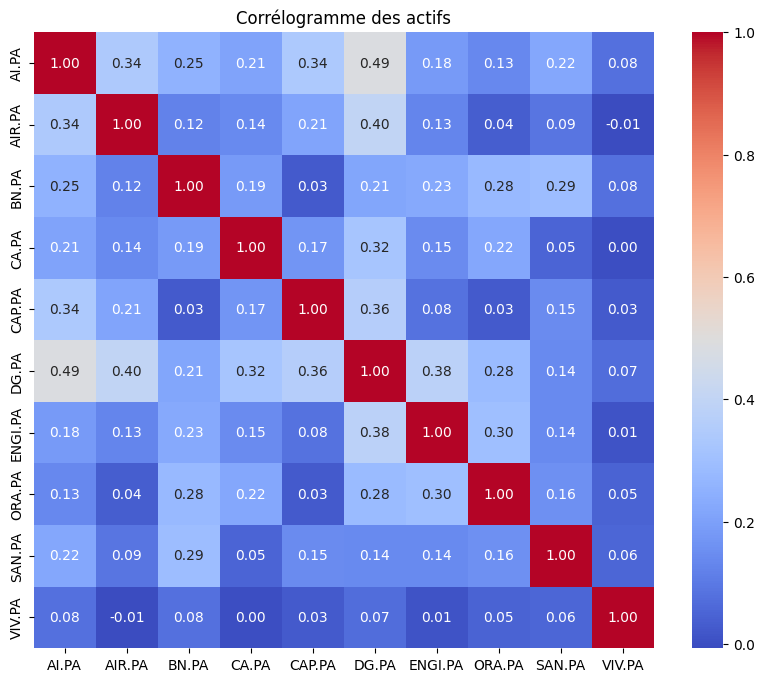

In [6]:
# Calcul de la matrice de corrélation
corr_actifs = returns.corr().to_numpy()

# Affichage du corrélogramme
plt.figure(figsize=(10, 8))
sns.heatmap(corr_actifs, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=returns.columns, yticklabels=returns.columns)
plt.title("Corrélogramme des actifs")
plt.show()


#### I.1.1 Présentation du principe d'optimisation de Markovitz

---

L'optimisation de Markowitz, également connue sous le nom de théorie moderne du portefeuille (MPT), permet de construire un portefeuille optimal en combinant des actifs de manière à minimiser la volatilité (ou le risque) tout en respectant une contrainte sur un niveau de rendement fixé. L'un des éléments clés de cette théorie est la détermination des poids de chaque actif dans le portefeuille, afin d'atteindre un compromis optimal entre le risque et le rendement.

--- 

 **Hypothèses principales :** 

1. Les décisions sont prises en fonction du couple **rendement-risque**.  
2. Les investisseurs cherchent à **diversifier** leurs actifs pour réduire le risque.  
3. L'accès au **taux sans risque** est illimité.  
4. **Aucun coût de transaction** n'est pris en compte.  

**Programme d'optimisation :**  
L'objectif est de **minimiser la volatilité** sous la contrainte d'un rendement cible $ \mu_T $ :  
$$
\text{Minimiser } \omega^t\Sigma \omega
$$
Sous les contraintes :

$$
\begin{cases} 
    \omega^t \mu = \mu_T \\
    \sum_{i=1}^{n} \omega_i = 1

\end{cases}
$$




---



#### I.1.2 Calcul des  rendements annualisées et des volatilités annualisés des log_rendements pour chaque actif

In [7]:

# Rendement annualisé

mean_daily_return= returns.mean()
yearly_return = (1+ mean_daily_return)**252 -1

# volatilité annualisé
sigma = returns.cov().to_numpy()
sigma = 252*sigma

#### I.1.3. Optimisation du portefeuille
L'investisseur a la latitude de shorter ou pas (via l'argument *Positive* de la foncion efficient_portfolio qui donne la latitude de lever la contrainte de positivité des coefficients), également de definir le niveau de rendement souhaité (via l'argument *mu_target* de la même fonction). 

Dans le cadre de l'exercice, pour des raisons de simplification et pour rester cohérent avec la suite, nous avons opté pour un portefeuille sur des positions longues.


In [8]:
from scipy.optimize import minimize
import numpy as np
 
# Nombre d'actifs
n_assets = len(yearly_return)
mu = yearly_return

def portfolio_variance(weights):
    return weights.T @ sigma @ weights

def weight_sum_constraint(weights):
    return np.sum(weights) - 1

def target_return_constraint(weights, mu_target):
    return weights.T @ mu - mu_target

def efficient_portfolio(mu_target, range_=(-0.1, None), positive=True):
    # On initialise les poids de maniere équitable
    init_weights = np.ones(n_assets) / n_assets

    # Contraintes
    constraints = [
        {'type': 'eq', 'fun': weight_sum_constraint},
        {'type': 'eq', 'fun': lambda w: target_return_constraint(w, mu_target)}
    ]

    # On verifie si on a définit une contrainte de positivité
    if positive:
        bounds = [(0, None) for _ in range(n_assets)]  # Chaque poids doit être >= 0
    else:
        bounds = [range_ for _ in range(n_assets)] 

    # Optimisation
    result = minimize(portfolio_variance, init_weights, bounds=bounds, method='SLSQP', constraints=constraints)

    if result.success:
        optimal_weights = result.x
        portfolio_volatility = np.sqrt(portfolio_variance(optimal_weights))
        return portfolio_volatility, optimal_weights
    else:
        return None, None


#### I.1.4  Illustration pour un rendement cible de 10%

--- 
Pour un rendement annuel cible de 10%, correspondant à l'ordre de grandeur des rendements du CAC40 qui représente le benchmark du fond, les poids optimaux donnés par le l'optimisation de Markovitz et qui ont permis de minimiser le risque auquel est exposé le porte feuille ( **9.67% de volatilité**) sont donnés ci après:

In [9]:
# Rendement cible
mu_target = 0.1 

# les poids optimaux et la volatilité
vol, weights = efficient_portfolio(mu_target)
print("Le portefeuille ainsi construit a un rendement de",round(weights.T @ mu,4), "et est soumis à une volatilité de l'ordre de :", round(vol,4), "\n")
print("---"*50)
print("Les poids associés aux actifs du porte feuille sont listés ci après:\n")
i = 0
for column in df_close.columns.tolist():
    print(f"{column}, {weights[i]:.4f}")
    i += 1


Le portefeuille ainsi construit a un rendement de 0.1 et est soumis à une volatilité de l'ordre de : 0.0989 

------------------------------------------------------------------------------------------------------------------------------------------------------
Les poids associés aux actifs du porte feuille sont listés ci après:

AI.PA, 0.0234
AIR.PA, 0.0399
BN.PA, 0.2027
CA.PA, 0.1928
CAP.PA, 0.1253
DG.PA, 0.0000
ENGI.PA, 0.0731
ORA.PA, 0.2652
SAN.PA, 0.0541
VIV.PA, 0.0235


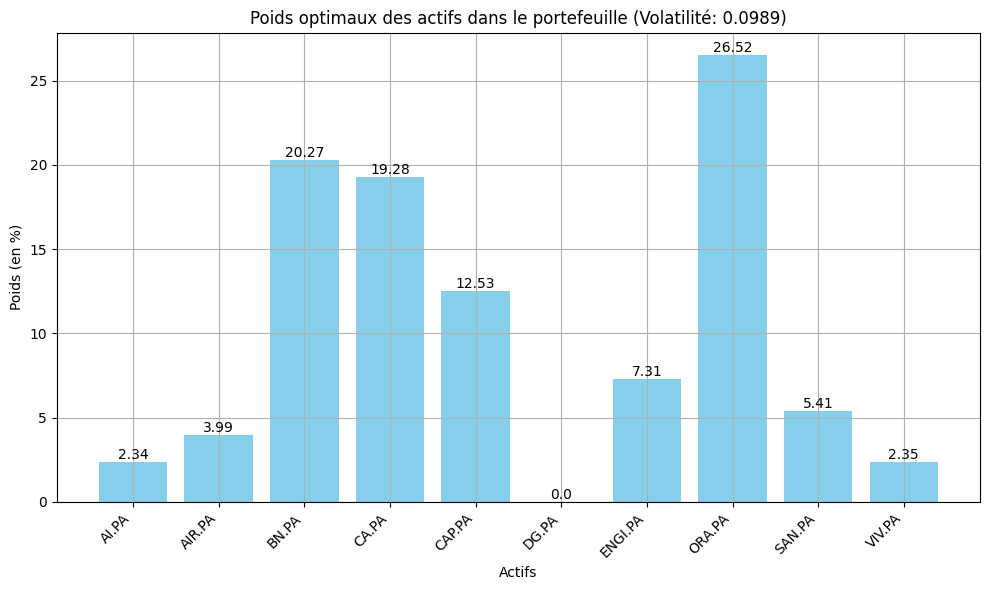

In [10]:
plt.figure(figsize=(10, 6))
bars = plt.bar(df_close.columns.tolist(), weights*100, color='skyblue')

plt.title(f"Poids optimaux des actifs dans le portefeuille (Volatilité: {round(vol, 4)})")
plt.xlabel("Actifs")
plt.ylabel("Poids (en %)")
plt.xticks(rotation=45, ha='right')
plt.grid(True)

# Ajout des étiquettes sur chaque barre
for bar, weight in zip(bars, weights):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{round(weight*100, 2)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


On constate que le portefeuille optimal est assez diversifié.Les trois principales entreipes representées sont :

- **Télécommunications** : Orange (26.53%) 
- **Banque et assurance** : BNP Paribas (20.24%), Credit Agricole (19.27%)
- **Technologie** : Capgemini (12.52%)
- **Énergie** : Engie (7.30%)  
 


## I.2.    Suivi du porte feuille 

---
Dans cette section on va determiner l'**AUM** du portefeuille, suivre ses **performances**, sa **volatilité** et ses **performances relatives** par rapport au CAC40.

Nous effectuerons également un **stress test** sur le portefeuille pour ebaluer sa sensibilité relative à la période COVID.

In [11]:
# Poids des actions dans le portefeuille
weights = pd.DataFrame({'Ticker': tickers ,
     'Weight': weights})
weights = weights.set_index('Ticker')['Weight']

#print(weights)

#### I.2.1. AUM : Asset under management

Elle représente la valeur du porte feuille et est déterminée par la formule suivante:

$$ AUM = NAV \times Nombre\_de\_ parts$$

Où :

La Net Value Asset (NAV) représente la valeur nette d'une part du fonds (portefeuille) à un moment donné.

In [12]:
# Détermination de l'AUM
aum = df_close@weights
portfolio = pd.DataFrame({'AUM': aum})
portfolio.head()

,AUM
Date,
2023-03-17,49.072221
2023-03-20,49.385656
2023-03-21,50.082637
2023-03-22,49.939933
2023-03-23,50.207391


In [13]:
portfolio.describe()

,AUM
count,509.000000
mean,55.279287
std,3.155878
min,49.072221
25%,52.209776
50%,55.565899
75%,57.952404
max,61.103492


Sur notre période d'etude, l'AUM en moyenne est de  59.10, et oscille entre 50.68 et 66.84.

#### I.2.2 Performance du portefeuille

---

Dans le cadre du suivi de notre portfeuille, il est important d'identifier et de mesurer les risques auxquels il est exposé afin de mieux les encadrer. Dans cette section nous intéressons tout particulièrement au risque de marché. Ce risque peut être évalué à l'aide de:

- La tracking error
- La volatilité
- La VaR 

qui sont des mesures ex-ante.

---

In [14]:
# Performance du portefeuille
portfolio['perf'] = portfolio['AUM'].pct_change()
portfolio.dropna(inplace=True)

# Performance du benchmark
cac40_df = cac40['Close']
cac40_df ['perf'] = cac40_df.pct_change()
cac40_df.dropna(inplace=True)

print("Rendement annualisé du fond: \t", (1+portfolio.perf.mean())**252 - 1)
print("Rendement annualisé du CAC40: \t", (1+cac40_df.perf.mean())**252 - 1)
print("Performance relative du fond: \t", (1+portfolio.perf.mean())**252 - (1+cac40_df.perf.mean())**252 )

Rendement annualisé du fond: 	 0.0824121025723723
Rendement annualisé du CAC40: 	 0.08502178188176579
Performance relative du fond: 	 -0.0026096793093934867


La performance absolue du fonds est de 8.24%, tandis que celle du CAC40 est de 8.50%.
Pour évaluer la performance relative du fonds par rapport à son indice de référence, on calcule l'écart de performance : -0.256%.
Cela signifie que le portefeuille sous-performe par rapport à son benchmark.

---

##### I.2.2.1 Tracking error

---
 La Tracking Error (TE) mesure l'écart de performance entre un fonds et son indice de référence (benchmark). Elle est définie comme l'écart-type des différences de rendement entre le fonds et le benchmark sur une période donnée. Plus la Tracking Error est faible, plus le fonds suit fidèlement son indice de référence.

$$
    TE = \sqrt{\frac{\sum_1^n (r_{fond} - r_{benchmark})^2}{n-1}}
$$

In [15]:
# Tracking error
portfolio['benchmark'] = cac40_df['perf']
portfolio['tracking_error'] = portfolio['perf'] - portfolio['benchmark']
TError = portfolio['tracking_error'].std()*np.sqrt(252) # Annualisation

TError

np.float64(0.10855409193042141)

Il ressort que la dispersion des rendements du fond par rapport ceux de son indice de reférence est de 10.8% en moyenne.

##### I.2.2.2 Volatilité

---
Afin d'evaluer le risque de marché du fond, la  volatilité complète l'information apportée par la tracking error et permet de se faire une idée sur la regularité et la dispersion des rendements du fond sur la periode d'étude. Il s'agit de l'écart-type des performances absolues du fond.

---


In [16]:
# Volatilité annualisé du portefeuille
std_dev = portfolio.std()*np.sqrt(252)
std_dev

AUM               49.955716
perf               0.131453
benchmark          0.128884
tracking_error     0.108554
dtype: float64

In [17]:

# Volatilité du benchmark
cac40_df.std()*np.sqrt(252)

Ticker
^FCHI    5304.018890
perf        0.128884
dtype: float64

Le portefeuille suivi a une volatilité annualisé de 13.13% qui est du même ordre de grandeur que celui de son benchmark (CAC40) dont la volatilité est de 12.89%.

##### I.2.2.3 Value at risk 

---
La value-at-risk (VaR) est une mesure très répendue en gestion de risques. Elle permet d'evaluer les pertes extrêmes encourrues sur un portefeuille sur un **horizon** donné sous un **niveau de confiance**. Elle est généralement calculée sur un horizon 1 jour. Pour obtenir une VaR sur un horizon (H) plus grand, on utilise la méthode de scaling qui consiste à multpiplier la VaR 1 jour par la racine carrée de H.

Elle est donnée par $\mathbf{P}(P \& L < VaR_H) = \alpha$

La VaR est déterminée à l'aide diverses approches:
- **Approche historique**: Elle consiste à calculer le quantile empirique d'ordre $\alpha$ des pertes historiques. C'est l'approche la plus utilisée en pratique. Cette méthode présente toutefois des limites en cas de changement soudain et inhabituel de conjoncture (crise etc.)

- **Approche paramétrique**: Ici on fait l'hypothèse que les P&L sont distribués suivant un loi dont les paramètres sont calibrés sur les données historiques. Comme toute méthode paramétrique, elle peut conduire à des estimations très biaisées si la loi supposée n'est pas adaptée aux données

---

<Axes: xlabel='perf', ylabel='Count'>

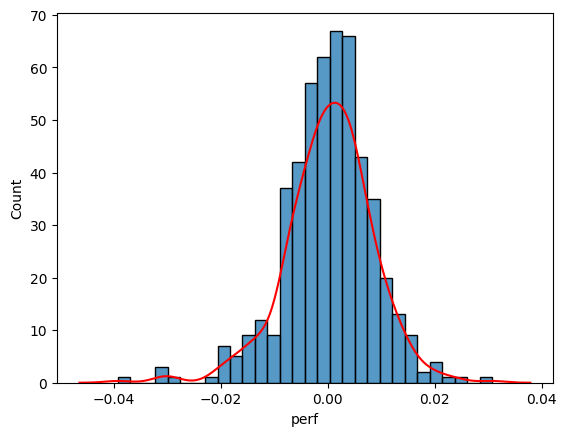

In [18]:
import seaborn as sns

sns.histplot(portfolio.perf)
sns.kdeplot(portfolio.perf, color='red')

In [19]:
portfolio[["perf","tracking_error"]].kurtosis() + 3

perf              5.195034
tracking_error    8.559272
dtype: float64

---
On s'interesse aux VaR sur un horizon de 20 jours

##### (a) VaR historique
---

In [20]:
VaR = portfolio.quantile(1-0.99)*np.sqrt(20) # 1-day VaR scaled to 20-day VaR
print("la VaR  P&L à 99% d'horizon 20 jours  est :",VaR[1])
print("la VaR  Relative à 99% d'horizon 20 jours  est :",VaR[3])

la VaR  P&L à 99% d'horizon 20 jours  est : -0.09706266334395498
la VaR  Relative à 99% d'horizon 20 jours  est : -0.08945021089128898


C:\Users\DEBA\AppData\Local\Temp\ipykernel_12460\764873701.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("la VaR  P&L à 99% d'horizon 20 jours  est :",VaR[1])
C:\Users\DEBA\AppData\Local\Temp\ipykernel_12460\764873701.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("la VaR  Relative à 99% d'horizon 20 jours  est :",VaR[3])


La perte maximale attendue sur un horizon de 20 jours avec un niveau de confiance de 99% est de 9.66%. 
Le porte feuille a 99% de chance de sous performer son indice de reference de 8.96% sur un horizon de 20 jours. 

##### (b) VaR paramétrique
---

In [21]:
VaR = (portfolio.mean() + norm.ppf(1-0.99)*portfolio.std())*np.sqrt(20)
print("la VaR  P&L à 99% d'horizon 20 jours  est :",VaR[1])
print("la VaR  Relative  à 99% d'horizon 20 jours  est :",VaR[3])

la VaR  P&L à 99% d'horizon 20 jours  est : -0.08474527854971078
la VaR  Relative  à 99% d'horizon 20 jours  est : -0.07118630738361904


C:\Users\DEBA\AppData\Local\Temp\ipykernel_12460\937860044.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("la VaR  P&L à 99% d'horizon 20 jours  est :",VaR[1])
C:\Users\DEBA\AppData\Local\Temp\ipykernel_12460\937860044.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("la VaR  Relative  à 99% d'horizon 20 jours  est :",VaR[3])


La perte maximale attendue sur un horizon de 20 jours avec un niveau de confiance de 99% est de 8.47%. 
Le porte feuille a 99% de chance de sous performer son indice de reference de 7.10% sur un horizon de 20 jours. 

---
On observe que les VaR paramétriques sont strictement inférieures aux VaR historiques. Ceci pourrait s'expliquer par le fait que les données ont des queues plus lourdes que la loi normale comme l'illustre le graphique présenté plus haut. De plus l'excess de kurtosis confirme cette observation. Par conséquent, la VaR obtenue sous une paramétrisation gaussienne sous-estime la perte maximale encourrue sur le portefeuille.

# Stress test
---
Le stress test ou test de résistance est un exercice qui consiste à reproduire des scénarios extrêmes sur un portefeuille afin d'évaluer sa résilience en conjoncture défavorable.
On distingue notamment deux types de stress test:
- Le stress test historique qui vise à reproduire des scénarios de crises historisques,
- Le stress test hypothétique qui consiste à considérer des scénarios théoriques extrêmes.

Nous allons dans la suite implémenter un stress test historique en reproduisant le choc COVID entre 19/02/2020 et 19/03/2020. Il s'agit s'agira de calculer la performance du fonds entre ces deux date et de la comparer à celle de son indice de référence.

In [22]:
# Données des actions en période covid
stress_date_1 = "2020-02-19"
stress_date_2 = "2020-03-19"

tickers = ['SAN.PA', 'BN.PA',  'AIR.PA', 'AI.PA', 'ORA.PA', 'CAP.PA', 'VIV.PA', 'CA.PA', 'ENGI.PA', 'DG.PA']
df_stress = yf.download(tickers, start = stress_date_1, end=stress_date_2)['Close']
cac40_stress = yf.download('^FCHI', start = stress_date_1, end=stress_date_2)['Close']

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


In [23]:
aum_stress = df_stress@weights
portfolio_stress = pd.DataFrame({'AUM': aum_stress})


In [24]:
# Rendement du portefeuille en période de covid
portfolio_stress.iloc[-1,] /portfolio_stress.iloc[0,]  - 1

AUM   -0.335606
dtype: float64

In [25]:
# Rendemnt du benchmark enn période covid
cac40_stress.iloc[-1,] / cac40_stress.iloc[0,] -1

Ticker
^FCHI   -0.385585
dtype: float64

Le fonds stressé a une performance absolue de -33.69% contre -38.55% pour son benchmark. Ces performances en période de crise COVID sont du même ordre de grandeur. Toutefois, la perte enregistrée sur le fonds est moins importante. Une analyse des performances des actions constituant le fonds montre que la sous-performance enegistrée est essentiellement portée par: Air Liquide, Capgenie et Engie.

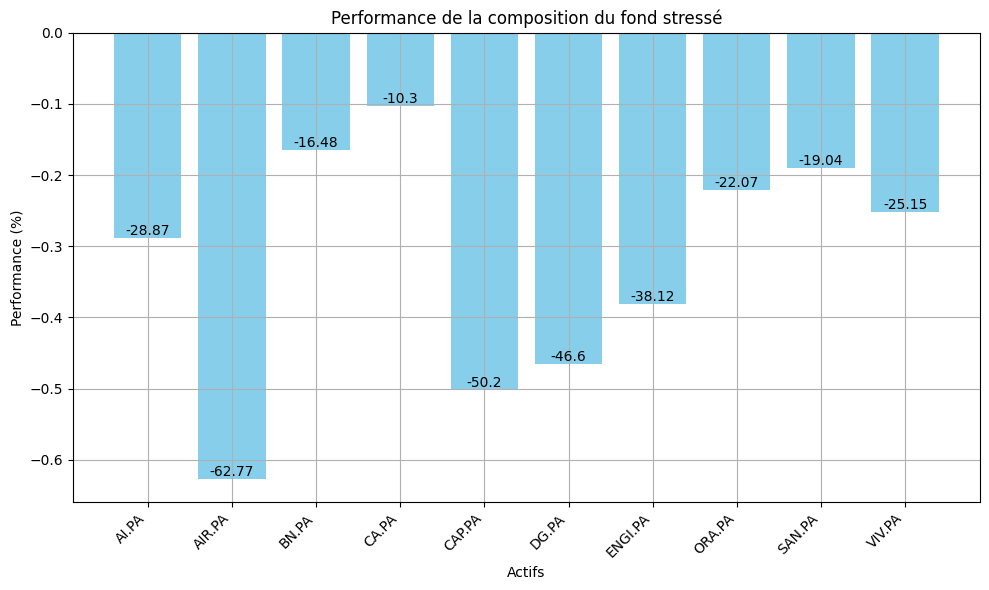

In [26]:
# Rendement du portefeuille en période de covid
df_stress.iloc[-1,] /df_stress.iloc[0,]  - 1

plt.figure(figsize=(10, 6))
bars = plt.bar(df_close.columns.tolist(), df_stress.iloc[-1,] /df_stress.iloc[0,]  - 1, color='skyblue')

plt.title(f"Performance de la composition du fond stressé")
plt.xlabel("Actifs")
plt.ylabel("Performance (%)")
plt.xticks(rotation=45, ha='right')
plt.grid(True)

# Ajout des étiquettes sur chaque barre
for bar, weight in zip(bars, df_stress.iloc[-1,] /df_stress.iloc[0,]  - 1):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{round(weight*100, 2)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


# Cadre de suivi de la liquidité

---
Le suivi de la liquidité est d'une importance centrale en gestion de fonds et est encadré par des exigences règlementaires. Il s'agit entre autres pour le gestionnaire de pouvoir honorer ses engagements vis-à-vis de des investisseurs en cas de rachat de parts du fonds. Il faut donc s'assurer de la capacité à revendre les actifs composant le fonds dans des délais courts sans toutefois les brader.

C'est ce qu'on appelle **le risque de liquidité** qui se défini plus formellement comme étant la facilité avec laquelle une entreprise peut échanger ses actifs contre du cash, même en situation soudaine de besoin de liquidité, sans subir de coûts anormaux par rapport aux autres acteurs du marché.

Le suivi de la liquidité d'un fonds s'effectue par le calcul de son profil d'écoulement en condition normale et en condition stressée.


---


**La méthodologie de calcul d'un profil d'écoulement**

Le fonds est constitué de n actifs en quantité $Q_i$ chacun à liquider. Dans la pratique il existe une quantité maximale au delà de laquelle les échanges ne peuvent se faire sans subir de coûts anormaux: c'est la **profondeur de marché**.  Le coût de liquidation est induit par les volume d'ordre émis.

La profondeur de marché est généralement estimée en examinant:
- Les carnets d'ordres ou
- Les volumes quotidiens échangés:
    On considère notamment le volume quotidien moyen échangé sur 3 mois appelé **ADV** ou **ATV** (**Average Daily/Traded Volume**). La profondeur de marché est alors estimée par $Q^* = 20\% \times ADV_{3 mois}$
    
---

On distingue quatre profils d'écoulement:
- En codition normale: avec et sans déformation
- En condition stressée: avec déformation et sans déformation

Dans une **liquidation avec déformation**, les actifs les plus liquides sont liquidés en premiers. La déformation du portefeuille s'illustre par les changements de poids des différents émetteurs dans le fonds. La **liquidation sans déformation** quant à elle consistera à liquider le fonds au rythme de l'actif le moins liquide afin de préserver les poids initiaux.

*N.B*: Le profil de liquidation est représenté en proportion du portefeuille initial.

On utilise le profil de liquidité pour déterminer la taille optimal du fonds permettant de respecter les exigence de minimum de liquidité. Il s'agira de s'assurer que plus de 90% du fonds est liquidé en deux jours,  laissant ainsi un maximum de 10 % dans la catégorie dite "**poubelle**" (c'est-à-dire les actifs moins liquides).


En condition stressée avec déformation: On se place dans une situation dans laquelle la profondeur de marché est réduite à la suite d'un choc conduisant à un assèchement du marché.

In [27]:
def liqudity(df_volume, ADV_rate=0.2, weight_adjust=1, label="Conditions normales avec déformation", seed = 42):
    """
    Fonction de calcul de la liquidité d'un portefeuille sur plusieurs jours.
    
    Paramètres :
    -----------
    df_volume : DataFrame
        DataFrame contenant les volumes quotidiens pour chaque actif (tickers).
    ADV_rate : float, optionnel
        Taux de liquidité journalière exprimé en pourcentage de l'ADV (par défaut 0.2, soit 20%).
    weight_adjust : float, optionnel
        Facteur de pondération pour ajuster la quantité générée aléatoirement (par défaut 1).
    label : str, optionnel
        Label pour décrire le scénario de liquidation (par défaut "Conditions normales avec déformation").

    Retourne :
    ---------
    portfolio_liquidity : DataFrame
        DataFrame contenant les informations suivantes pour chaque actif :
            - 'Ticker' : Le symbole de l'actif.
            - 'ADV' : Le volume moyen quotidien calculé sur une fenêtre de 60 jours.
            - 'Prix' : Le prix actuel de l'actif (extrait de df_close).
            - 'QUANTITE' : La quantité totale simulée de l'actif détenu par le portefeuille.
            - 'QUANTITE LIQUIDABLE' : La quantité qui peut être liquidée quotidiennement (ADV_rate * ADV).
            - 'NB_JOURS DE LIQUIDATION' : Nombre de jours estimés pour liquider entièrement l'actif.
            - 'JOUR X' (où X est un numéro de jour) : Quantité restante après chaque jour de liquidation.
            - 'POIDS X' : Poids relatif de chaque actif dans le portefeuille après chaque jour de liquidation.
    
    Description :
    -------------
    1. Calcul de l'Average Daily Volume (ADV) sur une fenêtre de 60 jours.
    2. Création d'un DataFrame contenant les informations de liquidité de chaque actif.
    3. Génération de quantités d'actifs aléatoires pour simuler un portefeuille.
    4. Calcul de la quantité liquidable par jour (20 % de l'ADV par défaut).
    5. Simulation de la liquidation progressive de chaque actif jour par jour jusqu'à épuisement.
    6. Calcul des poids du portefeuille après chaque jour de liquidation.
    
    """
    # Calcul de la moyenne mobile sur 60 jours du volume de transactions (ADV : Average Daily Volume)
    ADV = df_volume.rolling(window=60).mean()

    # Extraction de l'ADV le plus récent pour chaque ticker
    latest_ADV = ADV.iloc[-1,]

    # Création d'un DataFrame contenant l'ADV, le prix actuel et d'autres informations pour chaque actif
    portfolio_liquidity = pd.DataFrame({'Ticker': tickers, 'ADV': latest_ADV.values, 'Prix': df_close.iloc[-1,].values})

    # On définit la colonne 'Ticker' comme index pour faciliter l'accès aux données
    portfolio_liquidity = portfolio_liquidity.set_index('Ticker')

    # Génération de quantités d'actifs simulées basées sur l'ADV
    np.random.seed(seed)  # Pour des résultats reproductibles
    portfolio_liquidity['QUANTITE'] = weight_adjust * 1.5 * np.random.uniform(0, 1, 10) * portfolio_liquidity['ADV']

    # Calcul de la quantité liquidable : 20 % de l'ADV (peut être ajusté via 'ADV_rate')
    portfolio_liquidity['QUANTITE LIQUIDABLE'] = ADV_rate * portfolio_liquidity['ADV']

    # Calcul du nombre de jours nécessaires pour liquider chaque actif
    portfolio_liquidity['NB_JOURS DE LIQUIDATION'] = np.ceil(
        portfolio_liquidity['QUANTITE'] / portfolio_liquidity['QUANTITE LIQUIDABLE']
    )

    # Initialisation pour le jour 0
    i = 1
    portfolio_liquidity[f'POIDS {0}'] = portfolio_liquidity['QUANTITE'] * portfolio_liquidity['Prix']
    portfolio_liquidity[f'POIDS {0}'] = portfolio_liquidity[f'POIDS {0}'] / portfolio_liquidity[f'POIDS {0}'].sum()

    # Calcul de la quantité restante après le premier jour de liquidation
    portfolio_liquidity[f'JOUR {i}'] = portfolio_liquidity['QUANTITE'] - portfolio_liquidity['QUANTITE'].clip(upper=portfolio_liquidity['QUANTITE LIQUIDABLE'])
    portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'JOUR {i}'] * portfolio_liquidity['Prix']
    portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'POIDS {i}'] / portfolio_liquidity[f'POIDS {i}'].sum()

    # Calcul itératif jusqu'à liquidation complète
    while portfolio_liquidity[f'JOUR {i}'].max() > 0:
        i += 1
        # Calcul de la quantité restante après chaque jour supplémentaire
        portfolio_liquidity[f'JOUR {i}'] = (
            portfolio_liquidity[f'JOUR {i-1}'] - portfolio_liquidity[f'JOUR {i-1}'].clip(upper=portfolio_liquidity['QUANTITE LIQUIDABLE'])
        ).clip(lower=0)

        # Mise à jour des poids du portefeuille pour ce jour
        portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'JOUR {i}'] * portfolio_liquidity['Prix']
        portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'POIDS {i}'] / portfolio_liquidity[f'POIDS {i}'].sum()

    return portfolio_liquidity


In [28]:
def liquidity_profile(portfolio_liquidity, label="Profil d'écoulement en conditions normales avec déformation"):
    """
    Fonction qui génère un profil de liquidité d'un portefeuille en fonction du nombre de jours nécessaires pour liquider tous les actifs.

    Paramètres :
    -----------
    portfolio_liquidity : DataFrame
        Le DataFrame généré par la fonction liqudity() contenant les quantités restantes par jour pour chaque actif.
    label : str, optionnel
        Titre du graphique affiché (par défaut "Profil de liquidité en conditions normales avec déformation").

    Description :
    -------------
    1. Calcule la quantité restante d'actifs pour chaque jour jusqu'à liquidation totale.
    2. Calcule le profil de liquidité en pourcentage du portefeuille initial liquidé au fil du temps.
    3. Génère deux graphiques :
       - Profil de liquidité en pourcentage du portefeuille initial.
       - Évolution des poids des actifs au fil des jours.

    Retourne :
    ---------
    Affiche deux graphiques côte à côte montrant la liquidation progressive et l'évolution des poids.
    """
    # Calculer le profil de liquidité
    liquidity_profile = [portfolio_liquidity['QUANTITE']]
    for i in range(1, int(portfolio_liquidity['NB_JOURS DE LIQUIDATION'].max()) + 1):
        liquidity_profile.append(portfolio_liquidity[f'JOUR {i}'])

    liquidity_profile = pd.DataFrame(liquidity_profile)

    # Calculer le profil en pourcentage de liquidité restante
    profile = liquidity_profile @ portfolio_liquidity['Prix']
    portefeuille_valeur = profile['QUANTITE']  # Récupérer la valeur du portefeuille
    profile = 100 - profile[1:,] * 100 / portefeuille_valeur

    # Créer une figure avec deux sous-graphiques côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  

    # Premier graphique : Profil de liquidité
    ax1 = axes[0]
    profile.plot(ax=ax1, marker='o', legend=False, color='blue')
    barplot = profile.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black', alpha=0.5)

    # Affichage des valeurs sur les barres
    for bar in barplot.patches:
        value = round(bar.get_height(), 2)
        ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f"{value}",
                 ha='center', va='bottom', fontsize=10, color='black')

    ax1.set_title(f"{label}", fontsize=14)
    ax1.set_xlabel("Jours", fontsize=12)
    ax1.set_ylabel("Liquidité du portefeuille (%)", fontsize=12)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Étiquette de valeur du portefeuille
    ax1.text(0.95, 0.05, f"Valeur portefeuille : {round(portefeuille_valeur)} euros",
             transform=ax1.transAxes, fontsize=12, color='red', ha='right', va='bottom',
             bbox=dict(boxstyle="round", facecolor="white", edgecolor="red"))


    # Deuxième graphique : Évolution des poids
    ax2 = axes[1]
    for i in range(int(portfolio_liquidity['NB_JOURS DE LIQUIDATION'].max()) + 1):
        if f'POIDS {i}' in portfolio_liquidity.columns:
            ax2.plot(portfolio_liquidity[f'POIDS {i}'], label=f'Jour {i}')
        else:
            print(f"Colonne 'POIDS {i}' non trouvée.")

    ax2.set_title("Évolution des Poids au Fil des Jours", fontsize=14)
    ax2.set_xlabel("Index", fontsize=12)
    ax2.set_ylabel("Poids", fontsize=12)
    ax2.legend()
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajustement de l'affichage
    plt.tight_layout()
    plt.show()


## Profil d'écoulement avec déformation

### Profil d'écoulement en conditions normales avec déformation

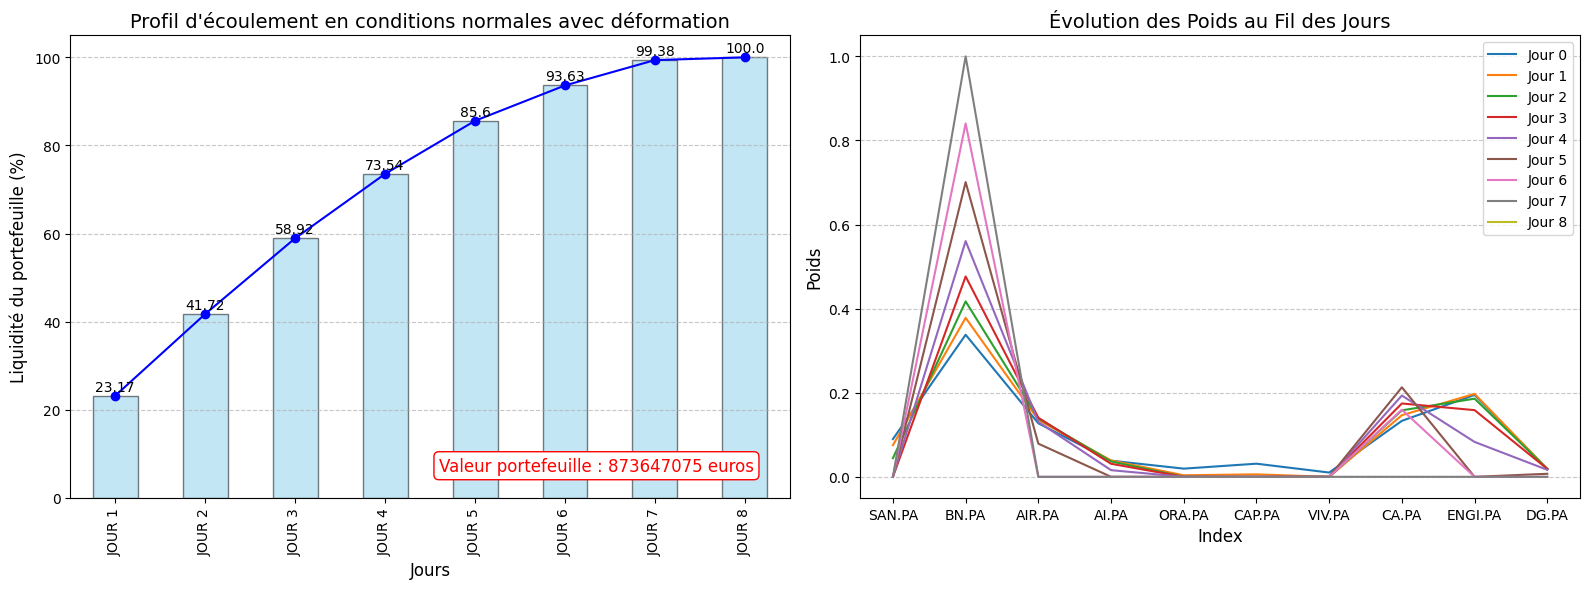

In [29]:
portfolio_liquidity = liqudity(df_volume)
liquidity_profile(portfolio_liquidity)

---

Le portefeuille étudié est liquidable en 8 jours au minimum. Au premier jour seul 23.17% du portefeuille est liquidable et atteint les 73.54% au 4eme jour.
On observe que les poids des actifs composant le portefeuille sont déformés au fil des jours. Il y a alors une concentration du portefeuille sur les actifs les moins liquides. Cette situation est domageable pour les investisseurs restant dans le fonds, car il faudra plus de temps pour honorer les engagements du fonds vis-à-vis d'eux en cas de rachat ce qui augmente leur exposition au **risque de liquidité.**.

Afin de protéger ces investisseurs, le régulateur impose aux gérants de fonds de fixer des **GATES** qui doivent obligatoirement être présentés dans leurs prospectus. Cela consiste à donner une option au gérant pour restreindre les rachats  quotidien, à 5% du fonds par exemple.

---

### Profil d'écoulement en conditions stressée avec déformation

---
En conjoncture défavorable, la profondeur de marché est réduite ce qui entraîne un contraction des volumes liquidables. 
Nous simulons un tel choc en réduisant la profondeur de marché à 10% l'ADV.

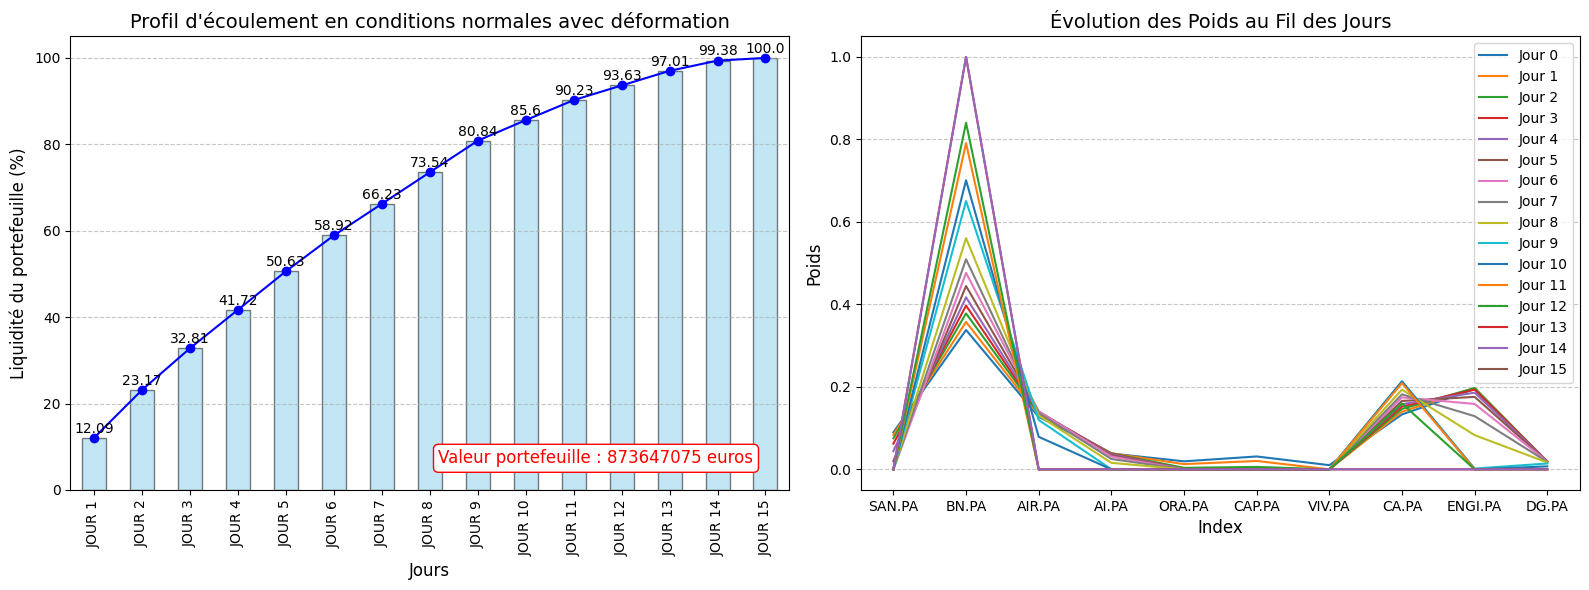

In [30]:
portfolio_liquidity = liqudity(df_volume, ADV_rate=0.1)
liquidity_profile(portfolio_liquidity)

---

La contraction de la profondeur de marché rallonge la durée minimale de liquidation du fonds à 15 jours contre 8 jours initialement. Ceci illustre bien l'exposition du fonds au risque de liquidité. Il devient donc indispensable pour le gérant du fonds de déterminer une **taille optimale** de celui-ci afin de réduire son exposition au risque de liquidité.

---


### Taille optimale du portefeuille
---
On peut ajuster la taille du portefeuille en faisant varier le paramètre *weight_adjust* de la fonction *liqudity* afin de déterminer la taille optimale du fonds liquidable en 1 jour.

Pour le cas étudié, le fonds optimal a une valeur de **123 184 238** euros dont 99.82% est liquidable en 1 jour.

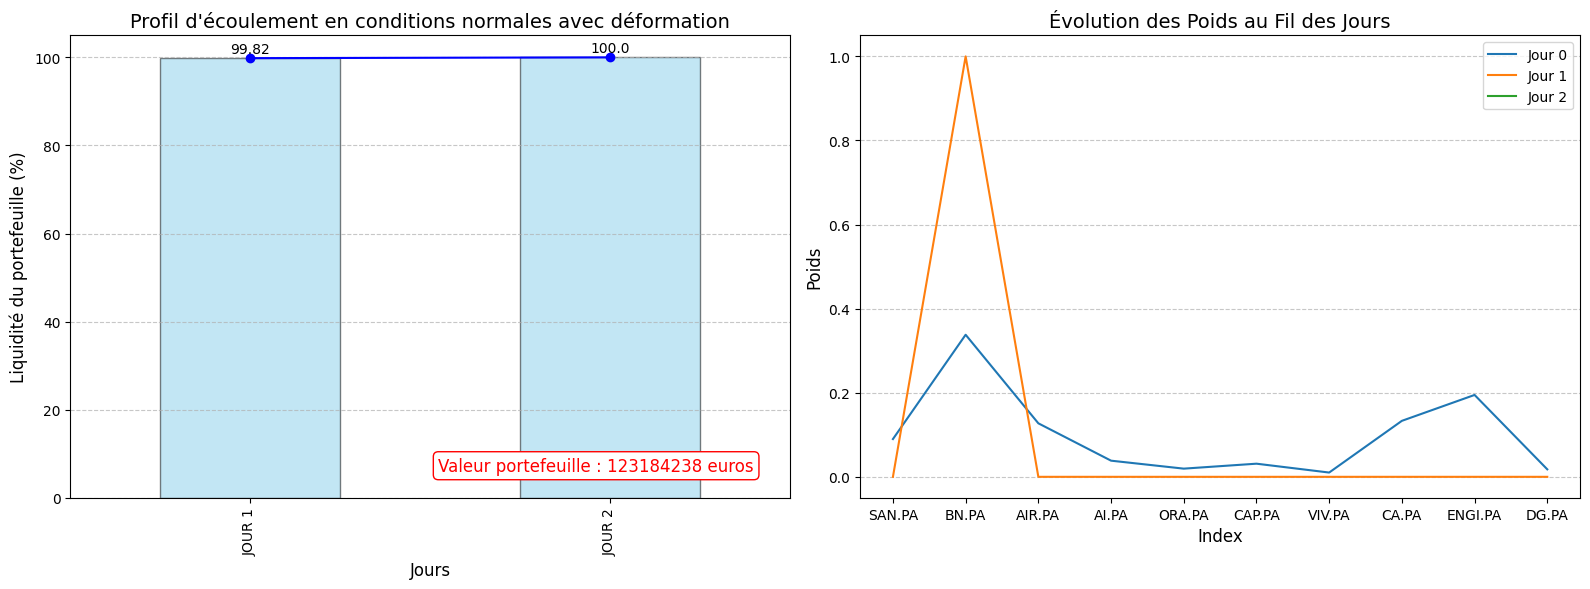

In [31]:
portfolio_liquidity = liqudity(df_volume, weight_adjust=0.141) # Taille optimale du portefeuille
liquidity_profile(portfolio_liquidity)

# Afficher la taille du portefeuille 123 184 238

En repétant le scénario défavorable d'un choc qui réduit la profondeur de marché à 10% l'ADV, le fonds optimal ainsi constitué est liquidable à 99.82% en deux jours. Il est donc plus résilient.

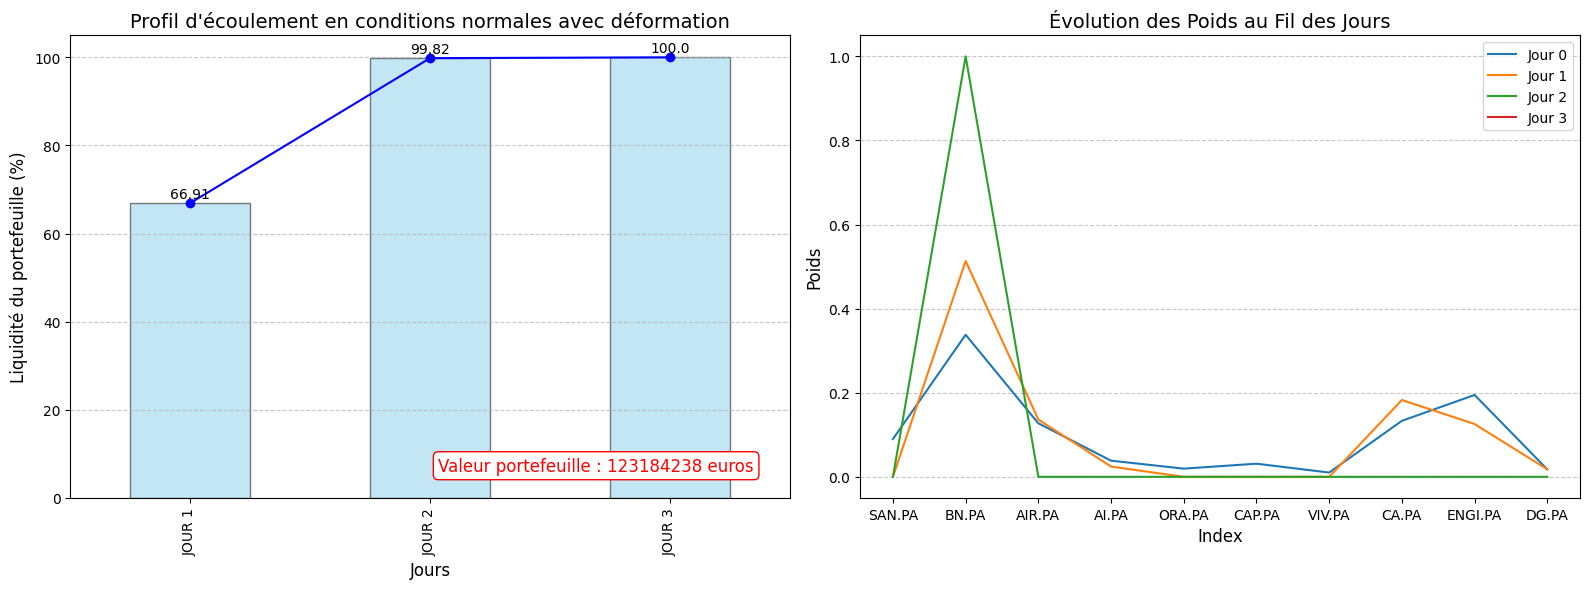

In [32]:
portfolio_liquidity = liqudity(df_volume, ADV_rate=0.1, weight_adjust=0.141) # Taille optimale du portefeuille
liquidity_profile(portfolio_liquidity)

# Afficher la taille du portefeuille 123 184 238

## Profil d'écoulement sans déformation

---

Rappelons qu'une politique de gestion sans déformation consiste à appliquer des rachats proformat. Ceci  garantisse une stabilité de la composition du fonds.

In [33]:
def liqudity_proformat(df_volume, ADV_rate = 0.2, weight_adjust = 1):
    """
    Fonction qui génère un DataFrame décrivant la liquidité d'un portefeuille sur plusieurs jours, en fonction de la quantité disponible par jour et des poids correspondants.

    Paramètres :
    -----------
    df_volume : DataFrame
        Un DataFrame contenant les volumes quotidiens de chaque ticker.
    ADV_rate : float, optionnel
        Le pourcentage d'Average Daily Volume (ADV) disponible chaque jour pour être liquidé (par défaut : 0.2, soit 20 %).
    weight_adjust : float, optionnel
        Facteur d'ajustement appliqué pour moduler la quantité calculée (par défaut : 1).

    Description :
    -------------
    1. Calcule l'ADV (volume moyen sur 60 jours) pour chaque actif.
    2. Génère un DataFrame contenant l'ADV, les prix actuels, les quantités à liquider, et les quantités liquidables par jour.
    3. Calcule le nombre de jours nécessaire pour liquider complètement chaque actif.
    4. Produit une série de DataFrames pour chaque jour, montrant la quantité restante, les poids associés, et les vitesses de liquidation.

    Retourne :
    ---------
    portfolio_liquidity : DataFrame
        Un DataFrame contenant les informations de liquidité du portefeuille sur plusieurs jours.
    """
    # Calcul de la moyenne mobile du volume (ADV) sur une fenêtre de 60 jours
    ADV = df_volume.rolling(window=60).mean()

    # Extraction de la dernière ligne (les valeurs ADV les plus récentes)
    latest_ADV = ADV.iloc[-1,]

    # Création d'un DataFrame pour la liquidité du portefeuille
    portfolio_liquidity = pd.DataFrame({'Ticker': tickers, 'ADV': latest_ADV.values, 'Prix': df_close.iloc[-1,].values})

    # Définir 'Ticker' comme index pour un accès plus facile
    portfolio_liquidity = portfolio_liquidity.set_index('Ticker')

    # Calcul de la quantité (QUANTITE) basée sur le volume le plus récent
    np.random.seed(42)
    portfolio_liquidity['QUANTITE'] = weight_adjust * 1.5 * np.random.uniform(0, 1, 10) * portfolio_liquidity['ADV']

    # Calcul de la quantité liquidable par jour
    portfolio_liquidity['QUANTITE LIQUIDABLE'] = ADV_rate * portfolio_liquidity['ADV']

    # Calcul du nombre de jours de liquidation nécessaire
    portfolio_liquidity['NB_JOURS DE LIQUIDATION'] = np.ceil(portfolio_liquidity['QUANTITE'] / portfolio_liquidity['QUANTITE LIQUIDABLE'])

    i = 1
    # Initialisation du premier jour
    portfolio_liquidity[f'POIDS {0}'] = portfolio_liquidity['QUANTITE'] * portfolio_liquidity['Prix']
    portfolio_liquidity[f'POIDS {0}'] = portfolio_liquidity[f'POIDS {0}'] / portfolio_liquidity[f'POIDS {0}'].sum()

    portfolio_liquidity[f'JOUR {i}'] = portfolio_liquidity['QUANTITE'] - portfolio_liquidity['QUANTITE'].clip(upper=portfolio_liquidity['QUANTITE LIQUIDABLE'])
    portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'JOUR {i}'] * portfolio_liquidity['Prix']
    portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'POIDS {i}'] / portfolio_liquidity[f'POIDS {i}'].sum()

    portfolio_liquidity[f'SPEED {i}'] = portfolio_liquidity['QUANTITE'].clip(upper=portfolio_liquidity['QUANTITE LIQUIDABLE']) / portfolio_liquidity['QUANTITE']

    while portfolio_liquidity[f'JOUR {i}'].max() > 0:
        i += 1
        portfolio_liquidity[f'JOUR {i}'] = (
            (portfolio_liquidity[f'JOUR {i-1}'] - portfolio_liquidity[f'JOUR {i-1}'] * portfolio_liquidity[f'SPEED {i-1}'].min())
        ).clip(lower=0)

        portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'JOUR {i}'] * portfolio_liquidity['Prix']
        portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'POIDS {i}'] / portfolio_liquidity[f'POIDS {i}'].sum()

        portfolio_liquidity[f'SPEED {i}'] = portfolio_liquidity[f'JOUR {i}'].clip(upper=portfolio_liquidity['QUANTITE LIQUIDABLE']) / portfolio_liquidity[f'JOUR {i}']

    return portfolio_liquidity


### Profil d'écoulement en conditions normales sans déformation

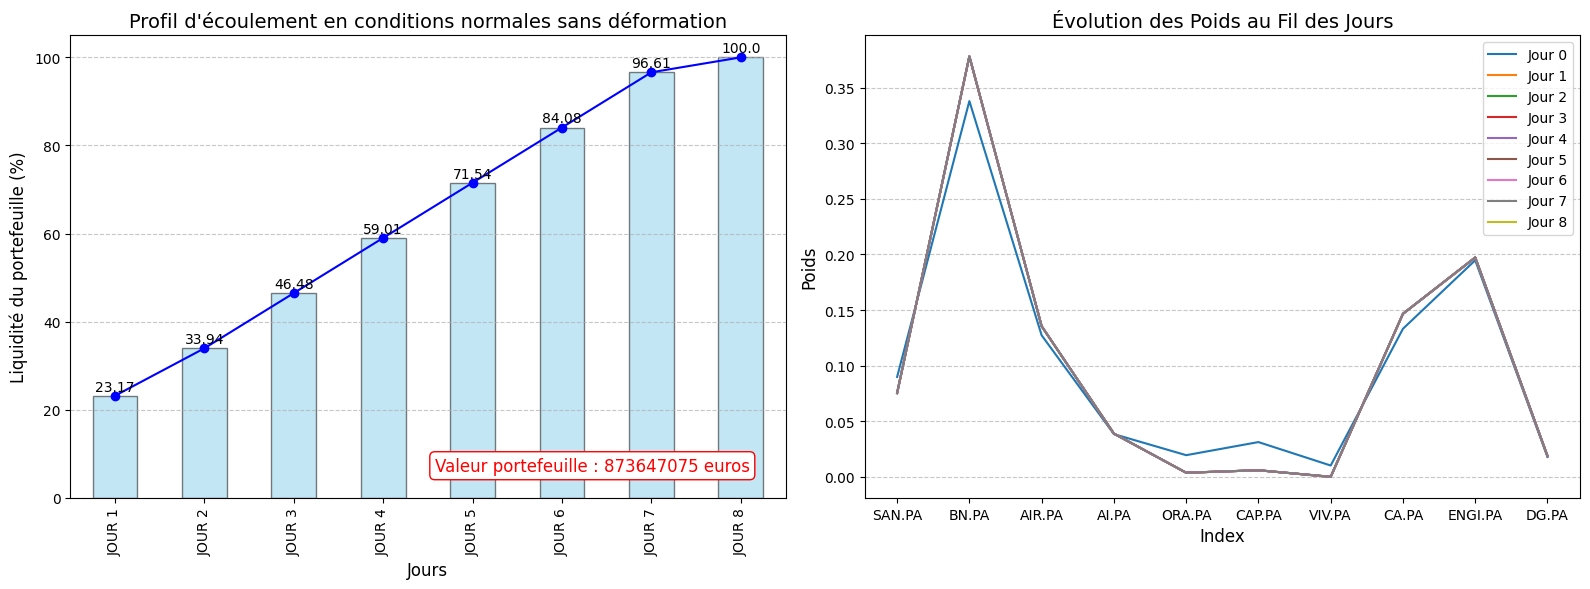

In [34]:
portfolio_liquidity = liqudity_proformat(df_volume)
liquidity_profile(portfolio_liquidity, label="Profil d'écoulement en conditions normales sans déformation")

---
Les actions étant liquidées à la vitesse d'écoulement de l'action la moins liquide, il apparaît clairement qu'à l'inverse d'un écoulement avec déformation la quantité liquidable évolue plus lentement. On a par exemple 59.01% du fonds liquidable en 4 jours contre 73.54% pour un écoulement avec déformation. 

Par ailleurs on constate bien que les poids des actions restent stables au fil des jours, sauf au dernier jour où la totalité du fonds est liquidée. Une implication immédiate de cette stabilité est qu'il n'y a pas de concentration du risque de liquidité sur des actifs les moins liquides du fonds.

---

### Profil d'écoulement en conditions stressée sans déformation

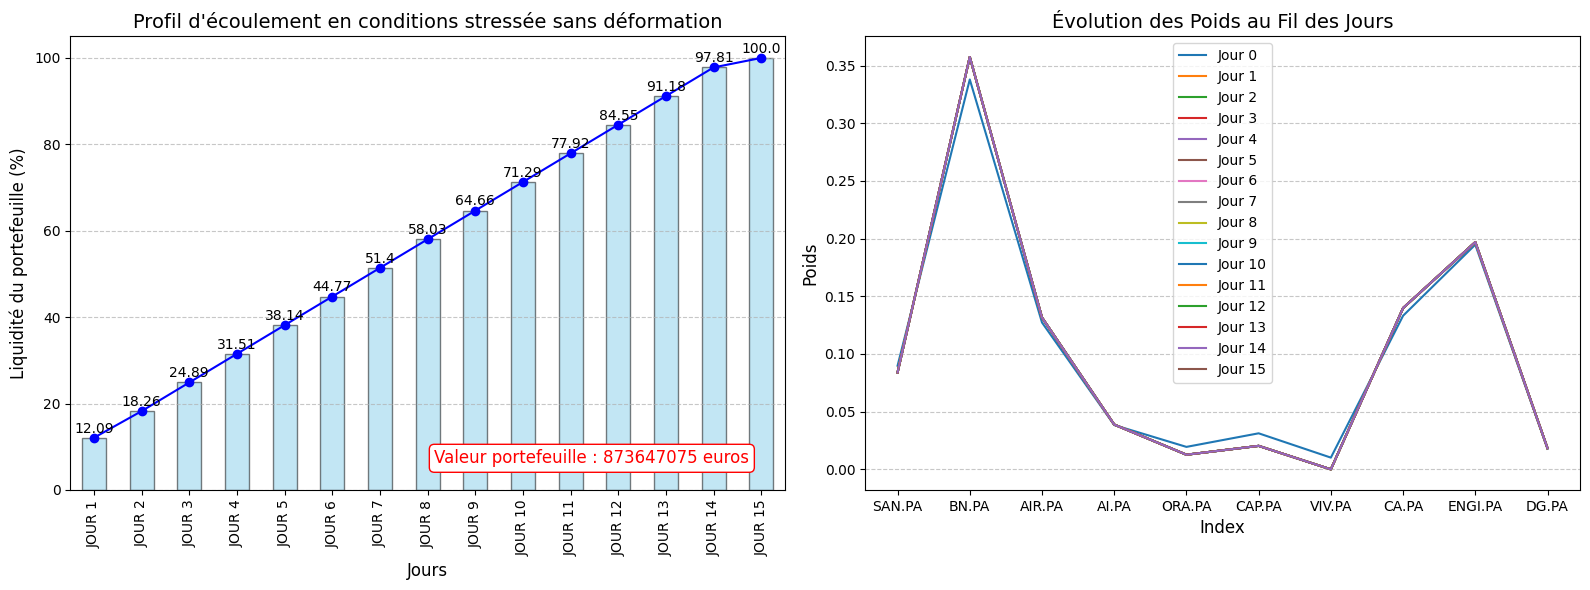

In [35]:
portfolio_liquidity = liqudity_proformat(df_volume, ADV_rate=0.1)
liquidity_profile(portfolio_liquidity, label="Profil d'écoulement en conditions stressée sans déformation")

Un choc sur la profondeur de marché a pour effet un rallongement de la durée minimale de liquidation du fonds. Toutefois, les poids restent bien stables.

# Risque de crédit et risque de taux
---

Le **risque de crédit** est le risque de perte engendrée par la defaillance d'une partie prenante à remplir ses engagements contractuels préalablement établis. C'est principal risque observé sur périmètre du retail.


On définit le **taux d'intérêt** comme   *le loyer de l'argent (annualisé dans la pratique)*.

Cette définition est celle historique car très intuitive. Il peut cependant s'averer que les taux d'interêt soient négatifs. Là cette definition devient donc limitée.


Depéndamment de ce qu'on fait de son argent, le thésauriser, le prêter à la banque , ou encore à l'etat, il existe toujours un risque de perte qui subsiste. Il peut donc advenir, que dans le souci de sécuriser son argent, dans un contexte particulier (notamment incertain), le posseusseur soit disposé à payer pour securiser son argent : on parle de taux d'intérêt négatif. 

Cela illustre la métaphore du **loyer du coffre fort**.

---


## Généralités sur le pricing d'obligations

CONTEXTE

En raison des obligations réglementaires auxquelles les banques sont soumises, elles ne peuvent pas prêter à toutes les entreprises ayant besoin de financement. C’est dans ce contexte que la notion d’obligation prend son sens. La banque agit alors en tant qu’intermédiaire entre l’entreprise et le marché, et perçoit des frais de commission. le marché prête un montant M à l'entreprise et reçoit des annuités et le nominal à maturité.

Une **obligation** est, économiquement, un prêt-emprunt. 

---
VALORISATION D'UNE OBLIGATION

---


De manière générale, la valorisation d'un actif  est l'espérance des flux actualisés au taux sans risque sous la probabilité risque neutre.

\begin{align}
X_0 &= E[e^{-rT}X_T]
    &= e^{-rT}c\times PS(T) 
\end{align}


**N.B**: *Taux de recouvrement historique est de 40%*. Le recouvrement s'applique uniquement au nominal.


La probabilité de survie PS est généralement déterminée à partir du modèle à intensité de Poisson via la relation
$$PS(T) = e^{-\lambda T}$$

Considérons une obligation d'échéances $T_i$, $i=1,...,n$, de coupon $c$ et de nominal $N$. Les coupons et le nominal sont payés en cas de survie et le recouvrement en cas de défaut.

La valeur de cette obligation à la date t vaut:

\begin{align}
    C_t = \sum_{i=1}^{n} c \times e^{-(\lambda+r)(T_i-t)} \mathbf{1}_{T_i \geq t}
\end{align}

---
La probabilité de survenu du défaut à une date t vaut
\begin{align}
    PD(t) &= PS(t) - PS(t+dt)
          &= - \frac{PS(t+dt)- PS(t)}{dt} dt
          &= - \frac{dPS(t)}{dt} dt
          &= \lambda e^{-\lambda t}dt
\end{align}

\begin{align}
    \mathcal{R}_0 &= \int_0^T R(\lambda e^{-\lambda t}) e^{-rt}dt
          &= \lambda R \frac{1 - e^{-(r+\lambda)T}}{r+\lambda}
\end{align}

\begin{align}
    \mathcal{R}_t &= \int_t^T R(\lambda e^{-\lambda u}) e^{-ru}du
          &= \lambda R \times e^{(r+\lambda)t} \frac{1 - e^{-(r+\lambda)T}}{r+\lambda} \mathbf{1}_{T \geq t}
\end{align}

\begin{align}
    B_t &= \sum_{i=1}^{n} c \times e^{-(\lambda+r)(T_i-t)} \mathbf{1}_{T_i \geq t} + \left(e^{-(r+\lambda)(T_n - t)} + \lambda R \times e^{(r+\lambda)t} \frac{1 - e^{-(r+\lambda)T_n}}{r+\lambda} \right) \mathbf{1}_{T_n \geq t}
\end{align}

## Impementation de la valorisation d'un bond

In [36]:
# Impementation de la fonctiuon de valorisation d'un bond
import numpy as np

def Bond(t,c,T,r,lamda, R = 0.4):
    B = 0
    for T_i in range(1,T+1):
        B += np.exp(-(lamda + r)*(T_i - t))*(T_i>=t)
    B *= c
    B += (np.exp(-(r + lamda)*(T_i-t)) + lamda * R  * (1-(np.exp(-(r + lamda)*(T_i -t)))) / (r + lamda))*(T_i>=t)
    return B

In [37]:
# Exemple1: Obligation au pair
lamda = 0
r = 0.02
c = 0.02
t = 0
T = 10
Bond(t,c,T,r,lamda)

np.float64(0.9981933497987289)

Avec les paramètres ci-dessus considérés, on remarque que le prix de l'obligation est proche du nominal. En effet, le taux coupon est égal au taux de marché, ce qui indique que l'obligation est remunérée au taux du marché. Il s'agit donc d'une obligation au pair.


Au cas où on aurait proposé une remunération supérieure à celle du marché, elle serait beaucoup plus attractive et sa valeur se serait appréciée. l'illustration est donnée ci dessous pour c= 0.03


In [38]:
price = Bond(0,0.03,10,0.02,0)
price

np.float64(1.0879246481591023)

Avec une remunération inférieure à ce qu'aurait proposé le marché, on obtient une valorisation de l'obligation inférieure au nomimal 

In [39]:
price = Bond(0,0.015,10,0.02,0)
price

np.float64(0.9533277006185421)

---
Etant donné une intensité de défaut supérieure à zéro, on peut également calculer le coupon pour lequel l'obligation est au pair. On obtient, après calculs prsentés ci-dessous, un taux coupon de 2.6%.

---

In [40]:
# Recherche du coupon  pour émettre une obligation au pair.
def dichot(t,T,r,lamda, P_MKT):
    c_inf = 1e-8
    c_sup = 1
    epsi = 1e-8
    c_moy = (c_inf + c_sup)/2
    error = c_sup - c_inf

    while error>epsi:
        p_hw = Bond(t,c_moy,T,r,lamda)
        if p_hw > P_MKT:
            c_sup = c_moy
        elif p_hw < P_MKT:
            c_inf = c_moy
        c_moy = (c_inf + c_sup)/2
        error = np.abs(c_sup - c_inf)

    return c_moy
    

In [41]:
# Taux coupon pour émettre une obligation au pair
lamda = 0.01
r = 0.02
t = 0
T = 10
dichot(t,T,r,lamda, P_MKT = 1)

0.026393926193952293

---
En maintenant une remunération égale à celle du marché , avec une intensité de défaut très grande (de l'ordre de 1000%), l'obligation tombe presque instantannément en défaut. Dans cette situation, la valeur du coupon vaut alors 39.92% qui est sensiblement proche du taux de recouvrement (40%). 

---


In [42]:
# Valeur du bond poiur une intensité de défaut à 1000%
lamda = 10
r = 0.02
c = 0.03
t = 0
T = 10
Bond(t,c,T,r,lamda)

np.float64(0.39920293189432754)

### Évolution du prix de l'obligation en fonction du temps

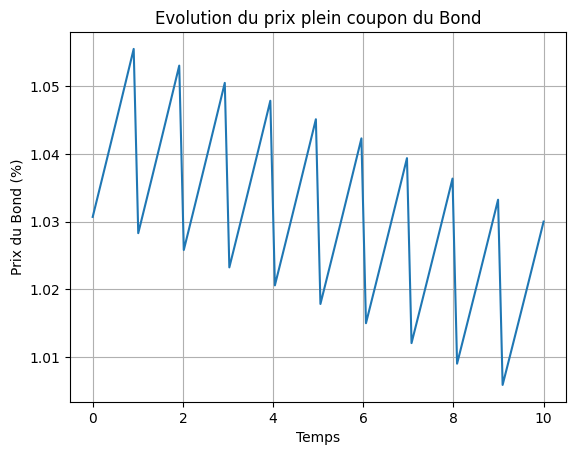

In [43]:

import matplotlib.pyplot as plt
lamda = 0.01
r = 0.02
c = 0.03
T = 10
times = np.linspace(0,10, num = 100)

B = np.array([Bond(t,c,T,r,lamda) for t in times])
plt.plot(times,B)
plt.xlabel("Temps")
plt.ylabel("Prix du Bond (%)")
plt.title("Evolution du prix plein coupon du Bond")
plt.grid(True)


---
Plus on se rapproche de la date de détachement du coupon plus l'obligation devient attractive, elle  prend donc de la valeur.

Chaque saut correspond à un détachement de coupons. une fois le coupon détaché de l'obligation, les flux à venir diminuent et la valeur de l'obligation se deprecie de la valeur du coupon qui a été détaché.

Ces sauts ne reflètent donc pas  une dépréciation des bonds par le marché. Ce sont des sauts techniques.
Raison pour laquelle on dit que le prix plein coupon est pollué par le coupon (en anglais **Dirty price**).


On va donc s'interesser par la suite au **clean price**  ou **pied de coupon**   qui correspond à au prix du bond moins le coupon couru.

\begin{align}
    \tilde{B}_t = B_t - cc
\end{align}
 où cc: coupon couru : 
 $$
    cc = c \times(t-T^*)
 $$
 Avec $T^*$ est la partie entière de t.

En retirant cette valeur de coupon couru, on supprime cet effet de saut après les detachements de coupons 

---

In [44]:

# Implémentation du clean price

def CleanPrice(t,c,T,r,lamda, R = 0.4):
    cc = c*(t - np.floor(t))*(t<=T)
    return Bond(t,c,T,r,lamda, R)-cc

Text(0.5, 1.0, 'Evolution du prix du Bond')

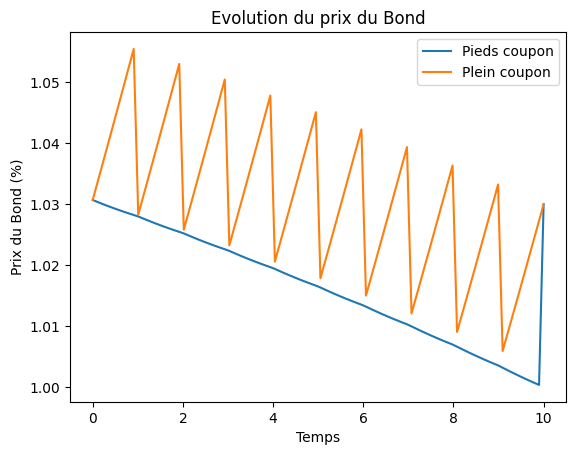

In [45]:
# Pieds coupon
lamda = 0.01
r = 0.02
c = 0.03
T = 10
times = np.linspace(0,10, num = 100)

B_plein_coupon = np.array([Bond(t,c,T,r,lamda) for t in times])
B_pieds_coupon = np.array([CleanPrice(t,c,T,r,lamda) for t in times])
plt.plot(times,B_pieds_coupon, label ="Pieds coupon")
plt.plot(times,B_plein_coupon, label ="Plein coupon")
plt.xlabel("Temps")
plt.ylabel("Prix du Bond (%)")
plt.legend()
plt.title("Evolution du prix du Bond")

En retirant cette valeur de coupon couru, on supprime l'effet de saut après les detachements de coupons, et on observe une courbe sans  discontinuités

In [46]:
##Evolution du prix plein coupon et du clean price en fonction du temps pour differents coupons

Text(0.5, 1.0, 'Evolution du prix du Bond')

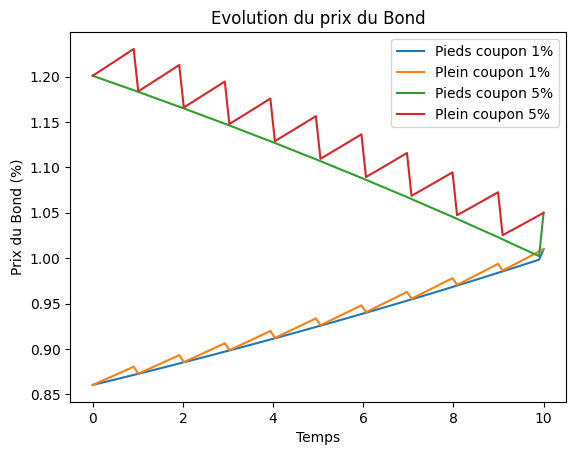

In [47]:
lamda = 0.01
r = 0.02
c = 0.01
T = 10

times = np.linspace(0,10, num = 100)
B_plein_coupon1 = np.array([Bond(t,0.01,T,r,lamda) for t in times])
B_pieds_coupon1 = np.array([CleanPrice(t,0.01,T,r,lamda) for t in times])

B_plein_coupon5 = np.array([Bond(t,0.05,T,r,lamda) for t in times])
B_pieds_coupon5 = np.array([CleanPrice(t,0.05,T,r,lamda) for t in times])

plt.plot(times,B_pieds_coupon1, label ="Pieds coupon 1%")
plt.plot(times,B_plein_coupon1, label ="Plein coupon 1%")

plt.plot(times,B_pieds_coupon5, label ="Pieds coupon 5%")
plt.plot(times,B_plein_coupon5, label ="Plein coupon 5%")
plt.xlabel("Temps")
plt.ylabel("Prix du Bond (%)")
plt.legend()
plt.title("Evolution du prix du Bond")


---
Les constats que l'on fait :
Lorsque c = 1% :
La rémunération de l'obligation est inférieure à celle offerte par le marché. Ainsi, lors de son émission, sa valeur sera nécessairement inférieure à celle du pair, ce qui explique une valeur initiale proche de 87 %. À maturité, on reçoit 100 % du nominal, plus 1 % de ce dernier, correspondant au coupon. Le résultat final est donc sensiblement égal à 101 %.

Lorsque c = 5% :
L'obligation rémunère plus que ce que le marché offre, ce qui la rend particulièrement attractive dès son émission. Ainsi, sa valeur de départ sera d'environ 120 %. Au fur et à mesure que les obligations sont détachées, les flux futurs diminuent, ce qui entraîne une dépréciation de sa valeur. À maturité, on reçoit 100 % du nominal, plus 5 % du montant nominal, correspondant au coupon. Le résultat final est donc de 105 %.

---


### Evolution du prix de l'obligation en fonction du taux d'intérêt
---
De l'expression analytique du prix du bond, on observe que le prix est décroissant du taux d'intérêt. La figure ci-dessous en donne une illustration, toute chose égale par ailleurs.

On vérifie graphiquement que le prix du bond est de 100% lorsque le taux d'intérêt est égal au taux sans risque $r^* = c - \lambda (1 - R)$.

Text(0.5, 1.0, "Evolution du prix du Bond en fonction du taux d'intérêt")

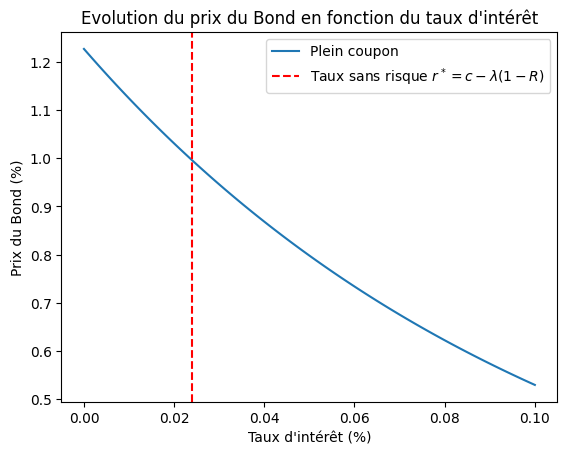

In [48]:
# Evolution du prix du bond en fonction du taux d'intérêt
lamda = 0.01
r = 0.02
c = 0.03
T = 10
R = 0.4
interest = np.linspace(0,0.10, num = 100)

B_plein_coupon = np.array([Bond(t,c,T,r,lamda) for r in interest])

plt.plot(interest,B_plein_coupon, label ="Plein coupon")
plt.axvline(x=(c - lamda*(1 - R) ), color='red', linestyle='--', label='Taux sans risque $r^* = c - \lambda (1 - R) $')
plt.xlabel("Taux d'intérêt (%)")
plt.ylabel("Prix du Bond (%)")
plt.legend()
plt.title("Evolution du prix du Bond en fonction du taux d'intérêt")

### Notion de sensibilité

La sensibilité mesure la variation du prix du bond face à une variation d'un facteur de risque.
On distingue entre autres la sensibilité de taux et la sensibilité de crédit.

---
Dans cette sectioin nous nous intéressons particulièrement à la sensibilité de taux. Elle est définie par la formule:

$$
    Sensibilité = - \frac{dB_t}{dr} \frac{1}{B_t}
$$


**Interprétation**: Lorsque le taux d'intérêt bouge de 1%, alors le prix du bond bouge de -sensibilité %.

 Cette sensibilité peut également être vue comme le barycentre des différentes échéances pondérées par les flux actualisés. C'est **la duration.**

$$
    \frac{\sum T_i\times F_i}{\sum F_i}
$$

Exemple: En considérant une obligation de maturité 3 ans payant des coupons annuels, avec intensité de défaut nul. Alors son prix et la sensibilité de taux sont données par:

\begin{align}
    P &=& c \times e^{-1r} + c \times e^{-2r} + c \times e^{-3r}
\end{align}

\begin{align}
    \frac{\partial P}{\partial r} &=& -1 c \times e^{-1r} -2 c \times e^{-2r} -3 c \times e^{-3r}
\end{align}

\begin{align}
    Sensibilité &=& \frac{1 c \times e^{-1r} + 2 c \times e^{-2r} + 3 c \times e^{-3r}}{c \times e^{-1r} + c \times e^{-2r} + c \times e^{-3r}}
\end{align}
D'où l'expression barycentrique des échéances pondérées par les flux.

In [49]:
# Sensibilité de taux du prix du bond
delta_r = 1e-4 #1bp


def Sensi(t,c,T,r,lamda, R = 0.4, delta_r = 1e-4):
    B_t = Bond(t,c,T,r,lamda, R)
    return -(Bond(t,c,T,r+delta_r,lamda, R)-B_t)/(delta_r*B_t)

On considère un bond dont les caractérisiques sont les suivqantes:

$$
    \begin{cases}
        \lambda = 0.01\\
        r = 0.02\\
        c = 0.03\\
        T = 10\\
        R = 0.4\\
    \end{cases}
$$

La sensiblité de ce bond est de 8.64. Ainsi,  lorsque le taux d'intérêt augmente de 1 point de pourcentage, le prix du bond diminue de 8.64%.


In [50]:
# Sensibilité de taux d'intérêt
Sensi(t,c,T,r,lamda, R = 0.4, delta_r = 1e-4)

np.float64(8.643982489105056)

#### Evolution de la sensibilité de taux fonction de la maturité

Text(0.5, 1.0, 'Sensibilité du prix du bond en fonction de la maturité')

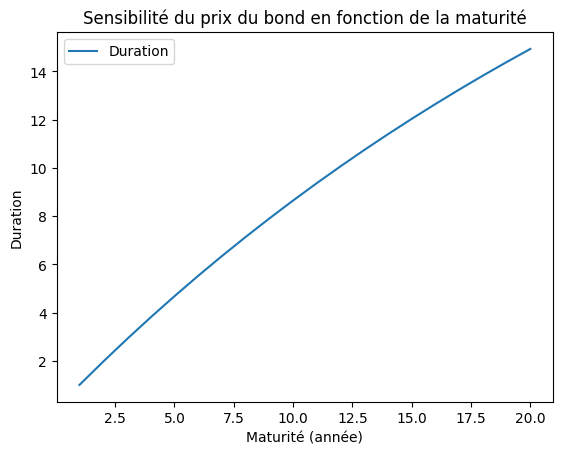

In [51]:
# Evolution de la sensibilité au taux d'intérêt en fonction de la maturité
maturity = range(1,21)
censi = np.array([Sensi(t,c,T,r,lamda) for T in maturity])

plt.plot(maturity, censi, label ="Duration")
plt.xlabel("Maturité (année)")
plt.ylabel("Duration")
plt.legend()
plt.title("Sensibilité du prix du bond en fonction de la maturité")

---
On constate que la sensibilité de taux croît avec la maturité et tend à être linéaire. ¨Pour des paramètres extrêmes $c = \lambda = r = 0$, la sensibilité (duration) est identique à la maturité comme illustré sur la figure ci-dessous. Cette remarque met en évidence la relation mlathématique entre la sensibilité et la maturité; on peut donc estimer la sensibilité avec peu d'information (variation du taux d'intérêt et la maturité, en approximant la duration par 0.8*maturité).

---

Text(0.5, 1.0, 'Sensibilité du prix du bond en fonction de la maturité (cas extrême)')

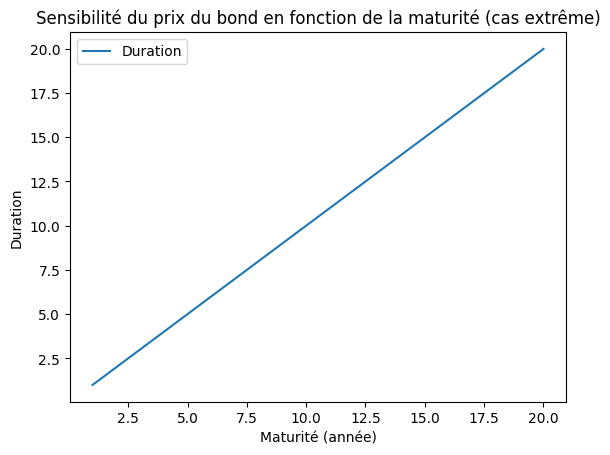

In [52]:
# Valeur extrême de la sensibilité (cas extrême de nullité de lambda, r et c)
maturity = range(1,21)
censi = np.array([Sensi(t,1e-6,T,1e-6,1e-6) for T in maturity])

plt.plot(maturity, censi, label ="Duration")
plt.xlabel("Maturité (année)")
plt.ylabel("Duration")
plt.legend()
plt.title("Sensibilité du prix du bond en fonction de la maturité (cas extrême)")

## Estimation de la VaR d'une obligation.

L'estimation de la VaR sur un bond peut se faire à partir de la senssibilité de taux ou par la méthode de repricing.

---

### Estiation de la VaR par la sensibilité de taux
---
L'approche dpar la sensibilité se présente de la manière suivante:

On suppose que la dynamique du taux d'intérêt donnée par $$\Delta r \sim \mathcal{N}(0, \sigma \sqrt{\Delta t})$$.

Sachant que $$\frac{\Delta P}{P} = - Duration \times \Delta r$$

il suit que $$\frac{\Delta P}{P} \sim \mathcal{N}(0, Duration \times \sigma \sqrt{\Delta t})$$

Une approche par la sensibilité de la VaR à 99% donne $$VaR = Duration \times \sigma \times  \sqrt{\Delta t} \times z_{99\%}$$
$\sigma = 1\%$


---

In [53]:
from scipy.stats import norm

# Calcul de la VaR par la sensibilité
def Sensi_VaR(sigma, H, t,c,T,r,lamda, R = 0.4, alpha=0.99):
    duration = Sensi(t,c,T,r,lamda, R)
    var = duration*sigma*np.sqrt(H)*norm.ppf(alpha)
    return var
    

In [54]:
sigma= 0.01
H = 1/12
t = 0
lamda = 0.01
r = 0.02
c = 0.03
T = 10
R =0.40

Sensi_VaR(sigma , H, t,c,T,r,lamda)

np.float64(0.05804942383590022)

---
La VaR à 99% d'horizon 1 an sur le bond est de 5.8%.
- On note que la VaR est une fonction linéaire croissante de la volatilité. C'est une conséquence directe de l'hypothèse de normalité des variations du taux d'intérêt. Ainsi, une augmentation de la volatilité du taux d'intérêt s'accompagne d'une augmentation de la volatilité du prix du bond.
- La VaR est une fonction décroissante du taux d'intérêt. En effet, une augmentation dest taux d'intérêt entraîne une diminution de la valeur des bonds, et par conséquent des valeurs extrêmes atteintes par celles-ci; d'où la VaR décroît. Toutefois l'évolution de la VaR en fonction du taux d'intérêt n'est pas linéaire.

---

#### Evolution de la Z-VaR en fonction du taux d'intérêt

Text(0.5, 1.0, 'VaR à 99% à horizon 1 an en fonction de la volatilité')

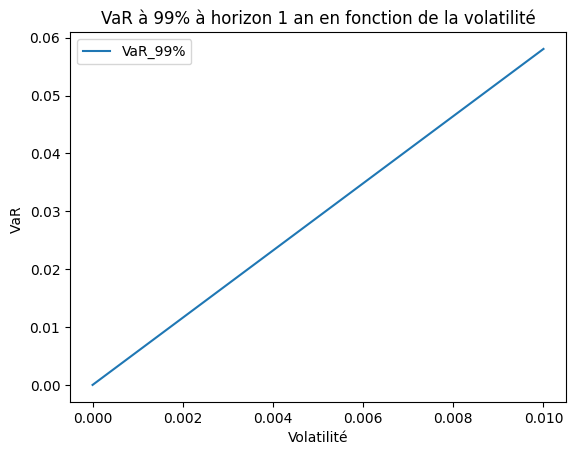

In [55]:
# Evolution de la VaR en fonction de la volatilité
vol = np.linspace(0,1e-2, num=100)
var = np.array([Sensi_VaR(sigma , H, t,c,T,r,lamda) for sigma in vol])

plt.plot(vol, var, label ="VaR_99%")
plt.xlabel("Volatilité")
plt.ylabel("VaR ")
plt.legend()
plt.title("VaR à 99% à horizon 1 an en fonction de la volatilité")

Text(0.5, 1.0, "VaR à 99% à horizon 1 an en fonction du taux d'intérêt")

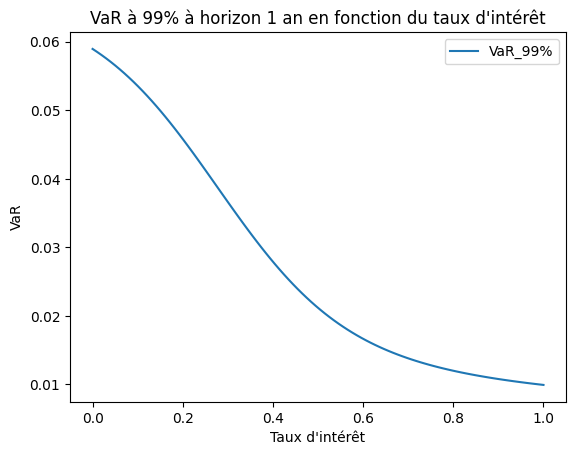

In [56]:
# Evolution de la VaR en fonction du taux d'intérêt
interest = np.linspace(0,1, num=100)
var = np.array([Sensi_VaR(sigma , H, t,c,T,r,lamda) for r in interest])

plt.plot(interest, var, label ="VaR_99%")
plt.xlabel("Taux d'intérêt")
plt.ylabel("VaR")
plt.legend()
plt.title("VaR à 99% à horizon 1 an en fonction du taux d'intérêt")

#### Evolution de la Z-VaR en fonction de l'intensité de défaut
---

Pour des intensités de défaut croissantes, la VaR du bond décroît de façon exponentielle, ceteris paridus.
Tout comme avec le taux d'intérêt, une augmentation de l'intensité de défaut s'accompagne d'une imminence du défaut et par conséquent de la diminution de la valeur du bond. D'où une diminution de la VaR.

---

Text(0.5, 1.0, "VaR à 99% à horizon 1 an en fonction de l'intensité de saut")

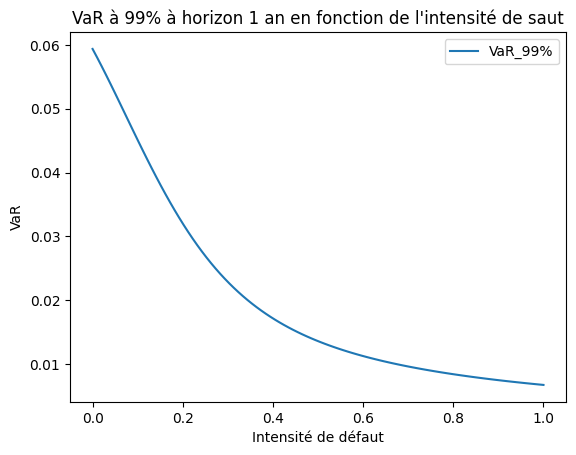

In [57]:
# Evolution de la VaR en fonction de l'intensité de défaut
lambdas = np.linspace(0,1, num=100)
var = np.array([Sensi_VaR(sigma , H, t,c,T,r,lamda) for lamda in lambdas])

plt.plot(lambdas, var, label ="VaR_99%")
plt.xlabel("Intensité de défaut")
plt.ylabel("VaR")
plt.legend()
plt.title("VaR à 99% à horizon 1 an en fonction de l'intensité de saut")

---
### Estimation de la VaR par repricing de l'obligation
---

La méthodologie consiste à revaloriser le bond pour une variation du taux d'intérêt, puis d'en déduire la variation du prix du bond qui en résulte.


$$
    \Delta r^* =\sigma \times  \sqrt{\Delta t} \times z_{99\%} 
$$

$$
    VaR_{99\%} = \frac{B(r+ \Delta r^*) - B(r)}{B(r)}
$$

---

In [69]:
# Approche repricing

def repricing_VaR(sigma, H, t,c,T,r,lamda, R = 0.4, alpha=0.99):
    delta_r = sigma*np.sqrt(H)*norm.ppf(alpha)
    B_rep = Bond(t,c,T,r+delta_r,lamda, R)
    B_r = Bond(t,c,T,r,lamda, R)
    
    return  (B_r - B_rep)/B_r


In [70]:
repricing_VaR(sigma, H, t,c,T,r,lamda, R = 0.4, alpha=0.99)

np.float64(0.05627224378244837)

---
- La VaR obtenue par l'approche repricing, sous les mêmes conditions que précédemment, est de 5.6%. Cette VaR est inférieure à celle obtenue sous l'hypothèse de normalité des variations du taux d'intérêt.

- Ceci s'explique par le fait que la duration est une fonction convexe du taux d'intérêt et représente une approximation affine de la valeur du bond en le taux d'intérêt. De manière générale, l'approche par les sensibilité surestime la VaR.
  
- L'évolution de la VaR, obtenue par reprincing, en fonction du taux d'intérêt ou de l'intensité de défaut à la même allure que la z-VaR.

- En règle générale la VaR doit être inférieur au seuil de 20% de part la limite règlementaire 20%. Les limites statutaires sont dès lors inférieures à cette limite règlementaire et permet aux proffessionnels de prendre des actions pour mieux couvrir le risque.

---

Text(0.5, 1.0, "VaR à 99% à horizon 1 an en fonction du taux d'intérêt")

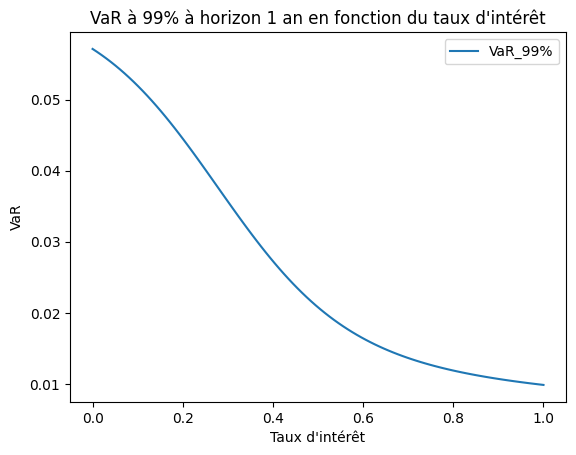

In [60]:
# Valeur extrême de la sensibilité (cas extrême de nullité de lambda, r et c)
interest = np.linspace(0,1, num=100)
var = np.array([repricing_VaR(sigma , H, t,c,T,r,lamda) for r in interest])

plt.plot(interest, var, label ="VaR_99%")
plt.xlabel("Taux d'intérêt")
plt.ylabel("VaR")
plt.legend()
plt.title("VaR à 99% à horizon 1 an en fonction du taux d'intérêt")

Text(0.5, 1.0, "VaR à 99% à horizon 1 an en fonction de l'intensité de défaut")

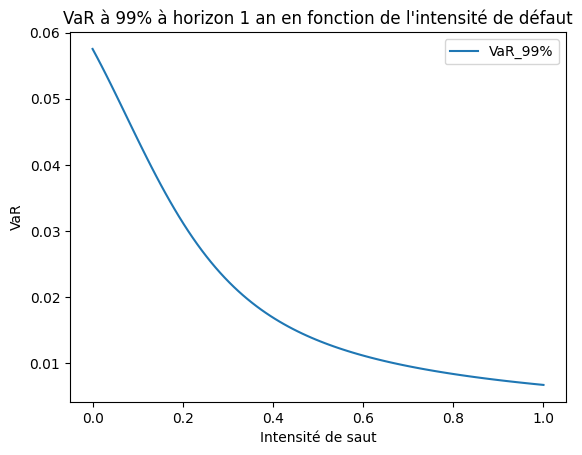

In [61]:
# Valeur extrême de la sensibilité (cas extrême de nullité de lambda, r et c)
lambdas = np.linspace(0,1, num=100)
var = np.array([repricing_VaR(sigma , H, t,c,T,r,lamda)for lamda in lambdas])

plt.plot(lambdas, var, label ="VaR_99%")
plt.xlabel("Intensité de saut")
plt.ylabel("VaR")
plt.legend()
plt.title("VaR à 99% à horizon 1 an en fonction de l'intensité de défaut")

# Risque de contrepartie
---

Lorsque la contrepartie est liée à l'émetteur on parle de wrong way risk. La contrepartie doit donc être décorrelée de l'émetteur.
Le risque de contrepartie est en général mitigé par les appels de marge (chambre de compensation).
- La qualité de l'émetteur se dégrade, le spread croît; le CDS s'apprécie.
- Si la contrepartie fait défaut, le détenteur perd $CDS = 1-R$
- Un mécanisme d'appel de marge permet de seggréguer 

---
## Lien entre CDS et obligation: la formule du triangle

Un estimation du taux sans risque d'une obligation:

\begin{align}
    P &= \sum_{i=1}^{n} c \times e^{-(\lambda+r)T_i}  + e^{-(r+\lambda)T_n } + \lambda R\frac{1 - e^{-(r+\lambda)T_n}}{r+\lambda} 
\end{align}

\begin{align}
    P &= c \int_0^T \times e^{-(\lambda+r)t}  + e^{-(r+\lambda)T } + \lambda R\frac{1 - e^{-(r+\lambda)T}}{r+\lambda} 
\end{align}

\begin{align}
    P &= c \frac{1 - e^{-(r+\lambda)T}}{r+\lambda}  + e^{-(r+\lambda)T } + \lambda R\frac{1 - e^{-(r+\lambda)T_n}}{r+\lambda} 
\end{align}

L'obligation est au pair si et seulement si P = 1
Ainsi,
$$
    (c + \lambda R) \frac{ 1- e^{-(r + \lambda )T}}{r + \lambda} + e^{-(r + \lambda)T} = 1
$$

Quand T tend vers l'infini le taux sans risque vaut alors,
$$
    (c + \lambda R)  = r + \lambda
$$

$$
    (c - r )  = \lambda (1 - R)
$$
- $c-r$: spread ou prime de risque
- $\lambda$: intensité de défaut
- $1-R$: LGD
$$
    Spread = PD \times LGD
$$

---
CDS: principe

- Premium Leg: est payé tant que l'émetteur est "en vie". $$ PL = \int_0^T s \times e^{-rt} \times e^{-\lambda t}dt = s \frac{1-e^{-(r+\lambda)T}}{r + \lambda}$$
- Default Leg: compensation à la date t si le défaut y survient. $$DL = \int_0^T(1-R) e^{-rt}\times e^{-\lambda t} dt = \lambda (1-R) \frac{1-e^{-(r+\lambda)T}}{r+\lambda}$$.

La valeur initiale d'un spread étant nulle, les deux jambes sont égales et il on obtient: 

$$
    s = \lambda (1-R)
$$

Un estimation de ce spread peut donc être déduite de la formule du triangle.


---

## Sensibilité de crédit

---

La sensibilité de crédit d'une obligation est la variation du prix de l'obligation lorsque varie le spread de crédit de la contrepartie. De la formule du triangle, la sensibilité de crédit peut être déduite de la sensibilité par rapport à l'intensité de défaut $\lambda$.


$$
    \frac{\partial P}{\partial s} = \frac{1}{1 - R} \frac{\partial P}{\partial \lambda}
$$

$$
    \frac{\partial P}{\partial s} \times \frac{1}{P}= \frac{1}{1 - R} \frac{\partial P}{\partial \lambda} \times  \frac{1}{P}
$$

On peut calculer une VaR taux et une VaR crédit. Toutefois, la VaR qui sera regarder de près est celle issue de la variation conjointe des taux et des spreads de crédit.

---

In [71]:
# Sensibilité de crédit du bond
delta_lambda = 1e-4 #1bp

def Sensi_credit(t,c,T,r,lamda, R = 0.4, delta_lambda = 1e-4):
    B_t = Bond(t,c,T,r,lamda, R)
    variation = -(Bond(t,c,T,r,lamda+delta_lambda, R)-B_t)/(delta_r*B_t)
    return variation/(1-R)

In [73]:
Sensi_credit(t,c,T,r,lamda)

np.float64(8.82119086802735)

---

- Une variation d'un point de pourcentage du spread de crédit entraîne une variation de 8.82% de la valeur du bond. Cette sensibilité de crédit est assez proche de la sensibilité taux. En effet, on observe de l'écriture mathématique de la valeur du bond que le taux d'intérêt et l'intensité apparaissent conjointement de façon additive (sauf pour le terme de recouvrement). 
  
- Ces deux sensibilitées sont identiques pour un taux de recouvrement nul.

---

In [64]:
Sensi_credit(t,c,T,r,lamda, R = 0.0, delta_lambda = 1e-4)

np.float64(8.77911216566412)

## Estimation de la VaR par variation conjointe du taux d'intérêt et du spread de crédit

---

On suppose que la dynamique du taux d'intérêt est donnée par l'EDS 

$$
    dr_t = \sigma dW_t
$$

Le spread ne prenant pas de valeur négative, on supposera qu'il est log-normal. Sa dynamique est donnée par l'EDS

$$
    \frac{ds_t}{s_t} = \alpha dZ_t
$$

En supposant $dW_t dZ_t = \rho$ et $Z_t = \rho W_t + \sqrt{1-\rho^2}V_t$ tel que  $dV_t dW_t = 0$,

La dynamique du spread s'écrit alors 
$$ 
\frac{ds_t}{s_t} = \alpha (\rho W_t + \sqrt{1-\rho^2}V_t)
$$

En appliquant un schéma de discrétisation d'Euler, on peut alors simuler les taux $r_t$ et les spread $s_t$ par:

$$
    r_H = r + \sigma \sqrt{H} W_H
$$

$$
    s_H = s(1 + \alpha \rho \sqrt{H} W_H + \alpha \sqrt{1-\rho^2} \sqrt{H} V_H)
$$

Où H est le pas de discrétisation.

---

La méthodologie de détermination de la sensibilité du prix d'une obligation conjointement au taux d'intérêt et au spread de crédit est la suivante:
- Calculer la valeur du bond pour les paramètres initiaux
- Simuler des les taux $r_H$ et les spread $s_H$
- Pour chaque simulation, calculer la valeur du bond (cetertis paridus)
- pour déterminer la variation des nouveaux prix par rapport au prix initial
- calculer le quantile d'ordre 99% des variations obtenues

---

In [75]:
# Sensibilité conjointe de taux et de crédit

def SimSpread(c,T,r,lamda, R, alpha, rho, H = 1/12, M=10_000):
    
    u1 = np.random.uniform(0,1, size = M)
    u2 = np.random.uniform(0,1, size = M)
    w = norm.ppf(u1)
    v = norm.ppf(u2)
    s = lamda*(1-R)
    
    r_H = r + sigma*np.sqrt(H)*w
    s_H = s*(1 + alpha*rho*np.sqrt(H)*w + alpha*np.sqrt(1-rho**2)*np.sqrt(H)*v)
    
    P_0 = Bond(0,c,T,r,lamda, R)
    P_1 = Bond(H,c,T,r_H,s_H/(1-R), R)
    mu = (P_1 - P_0)/P_0
    return  - np.quantile(mu,0.01)
    
    

In [ ]:
sigma = 0.01 # Volatilité du taux d'intérêt
alpha =0.4   # Volatilité du spread
rho = 0.4    # Corrélation entre le spread et le taux d'intérêt

np.random.seed(90) # Pour la reproductibilité
SimSpread(c,T,r,lamda, R, alpha, rho, H = 1/12)

np.float64(0.0602691861203251)

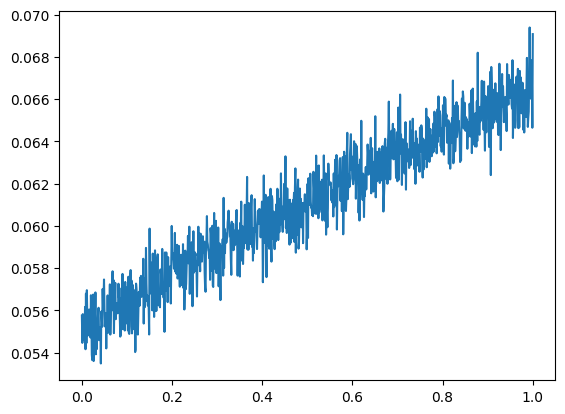

In [81]:
np.random.seed(90)

rhos = np.linspace(0,1, num= 1000)
var = np.array([SimSpread(c,T,r,lamda, R, alpha, rho, H = 1/12) for rho in rhos])

plt.plot(rhos, var)

---

La corrélation $\rho$ doit être positive, car une augmentation des taux d'intérêt entraîne une meilleure rémunération du marché par rapport aux obligations. Pour rester attractifs, les coupons doivent alors augmenter. Cette hausse des coupons accroît le coût de financement de l’émetteur, ce qui conduit à une augmentation du spread de crédit. Il en résulte une corrélation positive entre les taux d'intérêt et les spreads de crédit.

Une augmentation conjointe des taux et des spreads accroît le risque de défaut, en raison de la corrélation positive entre ces deux facteurs de risque. Ainsi, une corrélation élevée reflète un manque de diversification, ce qui expose davantage le portefeuille au risque systémique

---

# Risque modèle
- Sanity check: Ecart de performance
- Backtesting: Application aux données antérieures
- Comparaison avec desmodèles plus riches
- Provisionner au titre du risque de modèle

---

# Risque climatique

---
- Frein technique en terme de modélisation: pas de possibilité de faire du backtesting
- Réseau NGFS: Network for Greening financial System
- Scénarios climatiques
- Risque physique: risque lié aux évènements cliamtiques extrêmes. 
  - Risque aigu
  - Risque chronoique
- Risque de transition:
  - Risque politique: évolution de la règementation de plus en plus stricte pour (stratégie bas carbone).
  - Opportunuités technologiques

Les scénarios climatiques sont le pont pour passer des considération juridiques pour des considérations financières.
